# Scenario Selection Evaluation

This notebook validates the selected scenarios, plots representative graphs, and computes clustering metrics (e.g., silhouette score)


In [1]:
from pathlib import Path
import json
import os
import glob
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings

warnings.filterwarnings('ignore')


def find_repo_root(start=None):
    if start is None:
        start = Path.cwd()
    start = start.resolve()
    for parent in [start] + list(start.parents):
        if (parent / '.git').exists():
            return parent
        if (parent / 'data' / 'sub20' / 'graphs').exists():
            return parent
    raise FileNotFoundError("Could not find repo root (no .git or data/sub20/graphs found)")


ROOT = find_repo_root()

# Prefer repo-root graphs/ if it exists, otherwise fall back to data/sub20/graphs
if (ROOT / 'graphs').exists():
    GRAPHS_DIR = ROOT / 'graphs'
else:
    GRAPHS_DIR = ROOT / 'data' / 'sub20' / 'graphs'

OUTPUT_DIR = ROOT / 'src' / 'kernels' / 'outputs'
OUTPUT_DIR.mkdir(exist_ok=True)

print('ROOT:', ROOT)
print('GRAPHS_DIR:', GRAPHS_DIR)
print('OUTPUT_DIR:', OUTPUT_DIR)



ROOT: /Users/ignaciagothe/Desktop/proyecto graph kernels/graph_scenarios
GRAPHS_DIR: /Users/ignaciagothe/Desktop/proyecto graph kernels/graph_scenarios/data/sub20/graphs
OUTPUT_DIR: /Users/ignaciagothe/Desktop/proyecto graph kernels/graph_scenarios/src/kernels/outputs


In [2]:
# Load selection outputs
K_VALUES = [20, 100]


def load_selection(k):
    path_graphs = OUTPUT_DIR / f"selected_graphs_k{k}.json"
    path_scenarios = OUTPUT_DIR / f"selected_scenarios_k{k}.json"
    if path_graphs.exists():
        data = json.loads(path_graphs.read_text())
        data['_path'] = path_graphs
        data['_format'] = 'selected_graphs'
        return data
    if path_scenarios.exists():
        data = json.loads(path_scenarios.read_text())
        data['_path'] = path_scenarios
        data['_format'] = 'selected_scenarios'
        return data
    raise FileNotFoundError(f"No selection file found for k={k} in {OUTPUT_DIR}")


selections = {k: load_selection(k) for k in K_VALUES}
for k, data in selections.items():
    print(f"k={k} | format={data['_format']} | path={data['_path'].name}")


k=20 | format=selected_graphs | path=selected_graphs_k20.json
k=100 | format=selected_graphs | path=selected_graphs_k100.json


In [3]:
# Build graph file index (for validation)
pattern = None
for data in selections.values():
    if 'pattern' in data:
        pattern = data['pattern']
        break
if pattern is None:
    pattern = 'graph_*.pickle'

all_graph_files = sorted(glob.glob(str(GRAPHS_DIR / pattern)))
all_graph_basenames = [os.path.basename(p) for p in all_graph_files]
name_to_index = {name: idx for idx, name in enumerate(all_graph_basenames)}

print(f"Found {len(all_graph_files)} graphs using pattern '{pattern}'")


Found 49125 graphs using pattern 'graph_*.pickle'


In [4]:
# Parse selection outputs into a common shape and validate file selection

def parse_selection(data, k):
    selected_files = []
    selected_indices = None
    cluster_labels = None
    cluster_sizes = None

    if data['_format'] == 'selected_graphs':
        selected_files = data['selected_pickle_files']
        selected_indices = data.get('selected_indices')
        cluster_labels = np.array(data.get('cluster_labels', []), dtype=int)
        cluster_sizes = data.get('cluster_sizes')
    else:
        selected_files = [s['filename'] for s in data['selected_scenarios']]
        cluster_sizes = [s['cluster_size'] for s in data['selected_scenarios']]
        labels_path = OUTPUT_DIR / f"cluster_assignments_k{k}.npy"
        if labels_path.exists():
            cluster_labels = np.load(labels_path)

    # Validate selected files exist
    missing = [f for f in selected_files if f not in name_to_index]
    if missing:
        print(f"[warn] k={k}: missing files: {missing[:5]}{'...' if len(missing) > 5 else ''}")
    else:
        print(f"[ok] k={k}: all selected files exist")

    # Validate index mapping if provided
    if selected_indices is not None:
        mismatches = []
        for idx, fname in zip(selected_indices, selected_files):
            if idx >= len(all_graph_basenames) or all_graph_basenames[idx] != fname:
                mismatches.append((idx, fname))
        if mismatches:
            print(f"[warn] k={k}: index->filename mismatches: {mismatches[:3]}")
        else:
            print(f"[ok] k={k}: selected_indices match filenames")

    # Validate cluster sizes if labels are present
    label_counts = None
    if cluster_labels is not None and cluster_labels.size > 0:
        label_counts = np.bincount(cluster_labels, minlength=k)
        if cluster_sizes is not None and len(cluster_sizes) == k:
            if not np.all(label_counts == np.array(cluster_sizes)):
                print(f"[warn] k={k}: cluster_sizes do not match label counts")
            else:
                print(f"[ok] k={k}: cluster_sizes match label counts")
        if selected_indices is not None:
            # Medoid label should match its cluster id (order of medoids)
            bad_medoids = []
            for cluster_id, medoid_idx in enumerate(selected_indices):
                if medoid_idx < len(cluster_labels) and cluster_labels[medoid_idx] != cluster_id:
                    bad_medoids.append((cluster_id, medoid_idx, cluster_labels[medoid_idx]))
            if bad_medoids:
                print(f"[warn] k={k}: medoid label mismatches: {bad_medoids[:3]}")
            else:
                print(f"[ok] k={k}: medoid labels consistent")

    return {
        'selected_files': selected_files,
        'selected_indices': selected_indices,
        'cluster_labels': cluster_labels,
        'cluster_sizes': cluster_sizes,
        'label_counts': label_counts,
    }


parsed = {k: parse_selection(data, k) for k, data in selections.items()}


[ok] k=20: all selected files exist
[ok] k=20: selected_indices match filenames
[ok] k=20: cluster_sizes match label counts
[ok] k=20: medoid labels consistent
[ok] k=100: all selected files exist
[ok] k=100: selected_indices match filenames
[ok] k=100: cluster_sizes match label counts
[ok] k=100: medoid labels consistent


In [5]:
# --- WL features for full silhouette computation ---
import sys
from scipy import sparse
from tqdm import tqdm

kernels_dir = ROOT / 'src' / 'kernels'
if str(kernels_dir) not in sys.path:
    sys.path.append(str(kernels_dir))

from kernel_baseline import DirectedWLKernelHasher, row_l2_norms, row_normalize, load_nx_dag

# WL params from selection metadata (fallback defaults)
meta = selections[K_VALUES[0]]
wl_iterations = meta.get('wl_iterations', 3)
hash_dim = meta.get('hash_dim', 2**18)
node_label_attr = meta.get('node_label_attr')

X_cache = OUTPUT_DIR / f"wl_features_h{wl_iterations}_d{hash_dim}.npz"
if X_cache.exists():
    X = sparse.load_npz(X_cache)
    print(f"Loaded cached WL features: {X_cache} | shape={X.shape} nnz={X.nnz}")
else:
    hasher = DirectedWLKernelHasher(h=wl_iterations, hash_dim=hash_dim, node_label_attr=node_label_attr)
    rows, cols, data = [], [], []
    for i, path in enumerate(tqdm(all_graph_files, desc='Computing WL features')):
        G = load_nx_dag(path)
        fd = hasher._wl_features_one_graph(G)
        for c, v in fd.items():
            rows.append(i)
            cols.append(c)
            data.append(v)

    X = sparse.csr_matrix((data, (rows, cols)), shape=(len(all_graph_files), hash_dim), dtype=np.float64)
    sparse.save_npz(X_cache, X)
    print(f"Saved WL features: {X_cache} | shape={X.shape} nnz={X.nnz}")

norms = row_l2_norms(X)
Xn = row_normalize(X, norms)
print('Xn ready:', Xn.shape, 'nnz', Xn.nnz)



Loaded cached WL features: /Users/ignaciagothe/Desktop/proyecto graph kernels/graph_scenarios/src/kernels/outputs/wl_features_h3_d262144.npz | shape=(49125, 262144) nnz=19817686
Xn ready: (49125, 262144) nnz 19817686


In [6]:
# --- Full silhouette scores (no sampling) ---
from scipy import sparse


def full_silhouette_samples_from_Xn(Xn, labels, chunk_size=100):
    labels = np.asarray(labels, dtype=int)
    n = Xn.shape[0]
    k = int(labels.max()) + 1
    cluster_sizes = np.bincount(labels, minlength=k).astype(np.int64)
    if np.any(cluster_sizes == 0):
        raise ValueError('Empty cluster detected in labels')

    membership = sparse.csr_matrix(
        (np.ones(n, dtype=np.float64), (np.arange(n), labels)),
        shape=(n, k)
    )

    sil_samples = np.empty(n, dtype=np.float32)

    for start in tqdm(range(0, n, chunk_size), desc='Silhouette (full)'):
        end = min(start + chunk_size, n)
        Xc = Xn[start:end]

        # Similarity to all points
        S = (Xc @ Xn.T).toarray()
        np.clip(S, -1.0, 1.0, out=S)

        # Convert similarity to Euclidean distance on unit sphere: sqrt(2 - 2*cos)
        S *= -2.0
        S += 2.0
        np.maximum(S, 0.0, out=S)
        np.sqrt(S, out=S)  # now distances

        sums = S @ membership  # (m, k) sum distances to each cluster
        labels_chunk = labels[start:end]
        sizes = cluster_sizes[labels_chunk]

        sums_own = sums[np.arange(end - start), labels_chunk]
        a = np.zeros(end - start, dtype=np.float64)
        mask = sizes > 1
        a[mask] = sums_own[mask] / (sizes[mask] - 1)

        mean_other = sums / cluster_sizes
        mean_other[np.arange(end - start), labels_chunk] = np.inf
        b = np.min(mean_other, axis=1)

        s = (b - a) / np.maximum(a, b)
        s[~mask] = 0.0  # singleton clusters
        s[~np.isfinite(s)] = 0.0
        sil_samples[start:end] = s.astype(np.float32)

    return sil_samples


full_silhouette = {}
for k in K_VALUES:
    labels = parsed[k]['cluster_labels']
    if labels is None or len(labels) == 0:
        print(f'k={k}: no cluster labels available for silhouette')
        continue
    if len(labels) != len(all_graph_files):
        print(f'k={k}: label length {len(labels)} != n_graphs {len(all_graph_files)}, skipping')
        continue

    sil = full_silhouette_samples_from_Xn(Xn, labels, chunk_size=100)
    full_silhouette[k] = sil
    score = float(np.mean(sil))
    print(f'k={k} full silhouette: {score:.4f}')

    np.save(OUTPUT_DIR / f"silhouette_samples_k{k}.npy", sil)




Silhouette (full):   0%|          | 0/492 [00:00<?, ?it/s]

Silhouette (full):   0%|          | 1/492 [00:00<04:11,  1.95it/s]

Silhouette (full):   0%|          | 2/492 [00:00<03:59,  2.04it/s]

Silhouette (full):   1%|          | 3/492 [00:01<03:49,  2.13it/s]

Silhouette (full):   1%|          | 4/492 [00:01<03:46,  2.15it/s]

Silhouette (full):   1%|          | 5/492 [00:02<03:44,  2.17it/s]

Silhouette (full):   1%|          | 6/492 [00:02<03:43,  2.18it/s]

Silhouette (full):   1%|▏         | 7/492 [00:03<03:42,  2.18it/s]

Silhouette (full):   2%|▏         | 8/492 [00:03<03:40,  2.20it/s]

Silhouette (full):   2%|▏         | 9/492 [00:04<03:38,  2.21it/s]

Silhouette (full):   2%|▏         | 10/492 [00:04<03:36,  2.23it/s]

Silhouette (full):   2%|▏         | 11/492 [00:05<03:36,  2.22it/s]

Silhouette (full):   2%|▏         | 12/492 [00:05<03:36,  2.22it/s]

Silhouette (full):   3%|▎         | 13/492 [00:05<03:36,  2.21it/s]

Silhouette (full):   3%|▎         | 14/492 [00:06<03:36,  2.20it/s]

Silhouette (full):   3%|▎         | 15/492 [00:06<03:35,  2.21it/s]

Silhouette (full):   3%|▎         | 16/492 [00:07<03:34,  2.22it/s]

Silhouette (full):   3%|▎         | 17/492 [00:07<03:32,  2.23it/s]

Silhouette (full):   4%|▎         | 18/492 [00:08<03:33,  2.22it/s]

Silhouette (full):   4%|▍         | 19/492 [00:08<03:30,  2.24it/s]

Silhouette (full):   4%|▍         | 20/492 [00:09<03:27,  2.27it/s]

Silhouette (full):   4%|▍         | 21/492 [00:09<03:31,  2.23it/s]

Silhouette (full):   4%|▍         | 22/492 [00:09<03:32,  2.21it/s]

Silhouette (full):   5%|▍         | 23/492 [00:10<03:31,  2.22it/s]

Silhouette (full):   5%|▍         | 24/492 [00:10<03:26,  2.26it/s]

Silhouette (full):   5%|▌         | 25/492 [00:11<03:23,  2.29it/s]

Silhouette (full):   5%|▌         | 26/492 [00:11<03:25,  2.27it/s]

Silhouette (full):   5%|▌         | 27/492 [00:12<03:25,  2.26it/s]

Silhouette (full):   6%|▌         | 28/492 [00:12<03:22,  2.29it/s]

Silhouette (full):   6%|▌         | 29/492 [00:13<03:20,  2.31it/s]

Silhouette (full):   6%|▌         | 30/492 [00:13<03:21,  2.30it/s]

Silhouette (full):   6%|▋         | 31/492 [00:13<03:20,  2.30it/s]

Silhouette (full):   7%|▋         | 32/492 [00:14<03:17,  2.33it/s]

Silhouette (full):   7%|▋         | 33/492 [00:14<03:20,  2.29it/s]

Silhouette (full):   7%|▋         | 34/492 [00:15<03:22,  2.26it/s]

Silhouette (full):   7%|▋         | 35/492 [00:15<03:21,  2.27it/s]

Silhouette (full):   7%|▋         | 36/492 [00:16<03:19,  2.29it/s]

Silhouette (full):   8%|▊         | 37/492 [00:16<03:14,  2.33it/s]

Silhouette (full):   8%|▊         | 38/492 [00:16<03:15,  2.32it/s]

Silhouette (full):   8%|▊         | 39/492 [00:17<03:16,  2.30it/s]

Silhouette (full):   8%|▊         | 40/492 [00:17<03:16,  2.31it/s]

Silhouette (full):   8%|▊         | 41/492 [00:18<03:14,  2.32it/s]

Silhouette (full):   9%|▊         | 42/492 [00:18<03:18,  2.27it/s]

Silhouette (full):   9%|▊         | 43/492 [00:19<03:24,  2.20it/s]

Silhouette (full):   9%|▉         | 44/492 [00:19<03:26,  2.17it/s]

Silhouette (full):   9%|▉         | 45/492 [00:20<03:24,  2.19it/s]

Silhouette (full):   9%|▉         | 46/492 [00:20<03:23,  2.19it/s]

Silhouette (full):  10%|▉         | 47/492 [00:21<03:23,  2.19it/s]

Silhouette (full):  10%|▉         | 48/492 [00:21<03:20,  2.22it/s]

Silhouette (full):  10%|▉         | 49/492 [00:21<03:18,  2.24it/s]

Silhouette (full):  10%|█         | 50/492 [00:22<03:19,  2.21it/s]

Silhouette (full):  10%|█         | 51/492 [00:22<03:21,  2.19it/s]

Silhouette (full):  11%|█         | 52/492 [00:23<03:22,  2.17it/s]

Silhouette (full):  11%|█         | 53/492 [00:23<03:20,  2.19it/s]

Silhouette (full):  11%|█         | 54/492 [00:24<03:19,  2.19it/s]

Silhouette (full):  11%|█         | 55/492 [00:24<03:20,  2.18it/s]

Silhouette (full):  11%|█▏        | 56/492 [00:25<03:19,  2.19it/s]

Silhouette (full):  12%|█▏        | 57/492 [00:25<03:17,  2.20it/s]

Silhouette (full):  12%|█▏        | 58/492 [00:26<03:14,  2.24it/s]

Silhouette (full):  12%|█▏        | 59/492 [00:26<03:13,  2.24it/s]

Silhouette (full):  12%|█▏        | 60/492 [00:26<03:14,  2.22it/s]

Silhouette (full):  12%|█▏        | 61/492 [00:27<03:15,  2.21it/s]

Silhouette (full):  13%|█▎        | 62/492 [00:27<03:16,  2.19it/s]

Silhouette (full):  13%|█▎        | 63/492 [00:28<03:15,  2.20it/s]

Silhouette (full):  13%|█▎        | 64/492 [00:28<03:13,  2.21it/s]

Silhouette (full):  13%|█▎        | 65/492 [00:29<03:16,  2.18it/s]

Silhouette (full):  13%|█▎        | 66/492 [00:29<03:15,  2.18it/s]

Silhouette (full):  14%|█▎        | 67/492 [00:30<03:15,  2.17it/s]

Silhouette (full):  14%|█▍        | 68/492 [00:30<03:15,  2.17it/s]

Silhouette (full):  14%|█▍        | 69/492 [00:31<03:13,  2.18it/s]

Silhouette (full):  14%|█▍        | 70/492 [00:31<03:11,  2.20it/s]

Silhouette (full):  14%|█▍        | 71/492 [00:31<03:10,  2.21it/s]

Silhouette (full):  15%|█▍        | 72/492 [00:32<03:10,  2.21it/s]

Silhouette (full):  15%|█▍        | 73/492 [00:32<03:09,  2.21it/s]

Silhouette (full):  15%|█▌        | 74/492 [00:33<03:08,  2.22it/s]

Silhouette (full):  15%|█▌        | 75/492 [00:33<03:06,  2.23it/s]

Silhouette (full):  15%|█▌        | 76/492 [00:34<03:08,  2.21it/s]

Silhouette (full):  16%|█▌        | 77/492 [00:34<03:07,  2.21it/s]

Silhouette (full):  16%|█▌        | 78/492 [00:35<03:06,  2.21it/s]

Silhouette (full):  16%|█▌        | 79/492 [00:35<03:02,  2.26it/s]

Silhouette (full):  16%|█▋        | 80/492 [00:35<03:01,  2.27it/s]

Silhouette (full):  16%|█▋        | 81/492 [00:36<03:03,  2.23it/s]

Silhouette (full):  17%|█▋        | 82/492 [00:36<03:02,  2.25it/s]

Silhouette (full):  17%|█▋        | 83/492 [00:37<03:02,  2.24it/s]

Silhouette (full):  17%|█▋        | 84/492 [00:37<02:59,  2.27it/s]

Silhouette (full):  17%|█▋        | 85/492 [00:38<02:59,  2.27it/s]

Silhouette (full):  17%|█▋        | 86/492 [00:38<03:01,  2.24it/s]

Silhouette (full):  18%|█▊        | 87/492 [00:39<02:59,  2.25it/s]

Silhouette (full):  18%|█▊        | 88/492 [00:39<02:59,  2.25it/s]

Silhouette (full):  18%|█▊        | 89/492 [00:39<02:58,  2.26it/s]

Silhouette (full):  18%|█▊        | 90/492 [00:40<02:57,  2.26it/s]

Silhouette (full):  18%|█▊        | 91/492 [00:40<02:57,  2.25it/s]

Silhouette (full):  19%|█▊        | 92/492 [00:41<02:56,  2.27it/s]

Silhouette (full):  19%|█▉        | 93/492 [00:41<02:57,  2.25it/s]

Silhouette (full):  19%|█▉        | 94/492 [00:42<02:55,  2.26it/s]

Silhouette (full):  19%|█▉        | 95/492 [00:42<02:59,  2.21it/s]

Silhouette (full):  20%|█▉        | 96/492 [00:43<03:01,  2.19it/s]

Silhouette (full):  20%|█▉        | 97/492 [00:43<02:59,  2.20it/s]

Silhouette (full):  20%|█▉        | 98/492 [00:44<02:58,  2.21it/s]

Silhouette (full):  20%|██        | 99/492 [00:44<02:59,  2.19it/s]

Silhouette (full):  20%|██        | 100/492 [00:44<03:01,  2.16it/s]

Silhouette (full):  21%|██        | 101/492 [00:45<03:00,  2.17it/s]

Silhouette (full):  21%|██        | 102/492 [00:45<03:00,  2.15it/s]

Silhouette (full):  21%|██        | 103/492 [00:46<03:03,  2.12it/s]

Silhouette (full):  21%|██        | 104/492 [00:46<03:03,  2.11it/s]

Silhouette (full):  21%|██▏       | 105/492 [00:47<03:02,  2.12it/s]

Silhouette (full):  22%|██▏       | 106/492 [00:47<03:02,  2.11it/s]

Silhouette (full):  22%|██▏       | 107/492 [00:48<02:58,  2.15it/s]

Silhouette (full):  22%|██▏       | 108/492 [00:48<02:57,  2.17it/s]

Silhouette (full):  22%|██▏       | 109/492 [00:49<02:54,  2.20it/s]

Silhouette (full):  22%|██▏       | 110/492 [00:49<02:54,  2.19it/s]

Silhouette (full):  23%|██▎       | 111/492 [00:50<02:55,  2.17it/s]

Silhouette (full):  23%|██▎       | 112/492 [00:50<02:55,  2.16it/s]

Silhouette (full):  23%|██▎       | 113/492 [00:50<02:54,  2.17it/s]

Silhouette (full):  23%|██▎       | 114/492 [00:51<02:54,  2.17it/s]

Silhouette (full):  23%|██▎       | 115/492 [00:51<02:54,  2.16it/s]

Silhouette (full):  24%|██▎       | 116/492 [00:52<02:54,  2.16it/s]

Silhouette (full):  24%|██▍       | 117/492 [00:52<02:54,  2.16it/s]

Silhouette (full):  24%|██▍       | 118/492 [00:53<02:55,  2.13it/s]

Silhouette (full):  24%|██▍       | 119/492 [00:53<02:56,  2.12it/s]

Silhouette (full):  24%|██▍       | 120/492 [00:54<02:54,  2.13it/s]

Silhouette (full):  25%|██▍       | 121/492 [00:54<02:54,  2.13it/s]

Silhouette (full):  25%|██▍       | 122/492 [00:55<02:54,  2.12it/s]

Silhouette (full):  25%|██▌       | 123/492 [00:55<02:55,  2.10it/s]

Silhouette (full):  25%|██▌       | 124/492 [00:56<02:54,  2.11it/s]

Silhouette (full):  25%|██▌       | 125/492 [00:56<02:54,  2.10it/s]

Silhouette (full):  26%|██▌       | 126/492 [00:57<02:52,  2.12it/s]

Silhouette (full):  26%|██▌       | 127/492 [00:57<02:51,  2.12it/s]

Silhouette (full):  26%|██▌       | 128/492 [00:58<02:49,  2.15it/s]

Silhouette (full):  26%|██▌       | 129/492 [00:58<02:49,  2.15it/s]

Silhouette (full):  26%|██▋       | 130/492 [00:58<02:47,  2.16it/s]

Silhouette (full):  27%|██▋       | 131/492 [00:59<02:44,  2.19it/s]

Silhouette (full):  27%|██▋       | 132/492 [00:59<02:44,  2.19it/s]

Silhouette (full):  27%|██▋       | 133/492 [01:00<02:44,  2.18it/s]

Silhouette (full):  27%|██▋       | 134/492 [01:00<02:46,  2.16it/s]

Silhouette (full):  27%|██▋       | 135/492 [01:01<02:45,  2.16it/s]

Silhouette (full):  28%|██▊       | 136/492 [01:01<02:43,  2.18it/s]

Silhouette (full):  28%|██▊       | 137/492 [01:02<02:39,  2.22it/s]

Silhouette (full):  28%|██▊       | 138/492 [01:02<02:40,  2.20it/s]

Silhouette (full):  28%|██▊       | 139/492 [01:03<02:41,  2.18it/s]

Silhouette (full):  28%|██▊       | 140/492 [01:03<02:44,  2.14it/s]

Silhouette (full):  29%|██▊       | 141/492 [01:04<02:44,  2.13it/s]

Silhouette (full):  29%|██▉       | 142/492 [01:04<02:44,  2.13it/s]

Silhouette (full):  29%|██▉       | 143/492 [01:04<02:43,  2.13it/s]

Silhouette (full):  29%|██▉       | 144/492 [01:05<02:43,  2.13it/s]

Silhouette (full):  29%|██▉       | 145/492 [01:05<02:43,  2.12it/s]

Silhouette (full):  30%|██▉       | 146/492 [01:06<02:41,  2.15it/s]

Silhouette (full):  30%|██▉       | 147/492 [01:06<02:41,  2.14it/s]

Silhouette (full):  30%|███       | 148/492 [01:07<02:39,  2.16it/s]

Silhouette (full):  30%|███       | 149/492 [01:07<02:39,  2.16it/s]

Silhouette (full):  30%|███       | 150/492 [01:08<02:36,  2.18it/s]

Silhouette (full):  31%|███       | 151/492 [01:08<02:34,  2.21it/s]

Silhouette (full):  31%|███       | 152/492 [01:09<02:35,  2.19it/s]

Silhouette (full):  31%|███       | 153/492 [01:09<02:33,  2.21it/s]

Silhouette (full):  31%|███▏      | 154/492 [01:09<02:31,  2.23it/s]

Silhouette (full):  32%|███▏      | 155/492 [01:10<02:32,  2.21it/s]

Silhouette (full):  32%|███▏      | 156/492 [01:10<02:32,  2.21it/s]

Silhouette (full):  32%|███▏      | 157/492 [01:11<02:31,  2.22it/s]

Silhouette (full):  32%|███▏      | 158/492 [01:11<02:29,  2.23it/s]

Silhouette (full):  32%|███▏      | 159/492 [01:12<02:28,  2.24it/s]

Silhouette (full):  33%|███▎      | 160/492 [01:12<02:30,  2.20it/s]

Silhouette (full):  33%|███▎      | 161/492 [01:13<02:32,  2.18it/s]

Silhouette (full):  33%|███▎      | 162/492 [01:13<02:32,  2.17it/s]

Silhouette (full):  33%|███▎      | 163/492 [01:14<02:29,  2.20it/s]

Silhouette (full):  33%|███▎      | 164/492 [01:14<02:28,  2.21it/s]

Silhouette (full):  34%|███▎      | 165/492 [01:14<02:28,  2.20it/s]

Silhouette (full):  34%|███▎      | 166/492 [01:15<02:27,  2.20it/s]

Silhouette (full):  34%|███▍      | 167/492 [01:15<02:25,  2.23it/s]

Silhouette (full):  34%|███▍      | 168/492 [01:16<02:24,  2.24it/s]

Silhouette (full):  34%|███▍      | 169/492 [01:16<02:23,  2.25it/s]

Silhouette (full):  35%|███▍      | 170/492 [01:17<02:24,  2.23it/s]

Silhouette (full):  35%|███▍      | 171/492 [01:17<02:25,  2.21it/s]

Silhouette (full):  35%|███▍      | 172/492 [01:18<02:26,  2.18it/s]

Silhouette (full):  35%|███▌      | 173/492 [01:18<02:25,  2.19it/s]

Silhouette (full):  35%|███▌      | 174/492 [01:19<02:25,  2.18it/s]

Silhouette (full):  36%|███▌      | 175/492 [01:19<02:27,  2.14it/s]

Silhouette (full):  36%|███▌      | 176/492 [01:20<02:28,  2.13it/s]

Silhouette (full):  36%|███▌      | 177/492 [01:20<02:27,  2.13it/s]

Silhouette (full):  36%|███▌      | 178/492 [01:23<05:43,  1.09s/it]

Silhouette (full):  36%|███▋      | 179/492 [01:35<22:49,  4.37s/it]

Silhouette (full):  37%|███▋      | 180/492 [01:54<45:52,  8.82s/it]

Silhouette (full):  37%|███▋      | 181/492 [02:01<42:35,  8.22s/it]

Silhouette (full):  37%|███▋      | 182/492 [02:03<34:03,  6.59s/it]

Silhouette (full):  37%|███▋      | 183/492 [02:06<28:23,  5.51s/it]

Silhouette (full):  37%|███▋      | 184/492 [02:09<24:10,  4.71s/it]

Silhouette (full):  38%|███▊      | 185/492 [02:24<39:08,  7.65s/it]

Silhouette (full):  38%|███▊      | 186/492 [02:27<32:11,  6.31s/it]

Silhouette (full):  38%|███▊      | 187/492 [02:29<25:43,  5.06s/it]

Silhouette (full):  38%|███▊      | 188/492 [02:29<18:36,  3.67s/it]

Silhouette (full):  38%|███▊      | 189/492 [02:30<13:39,  2.70s/it]

Silhouette (full):  39%|███▊      | 190/492 [02:30<10:11,  2.03s/it]

Silhouette (full):  39%|███▉      | 191/492 [02:31<07:46,  1.55s/it]

Silhouette (full):  39%|███▉      | 192/492 [02:31<06:04,  1.22s/it]

Silhouette (full):  39%|███▉      | 193/492 [02:32<04:52,  1.02it/s]

Silhouette (full):  39%|███▉      | 194/492 [02:32<04:03,  1.22it/s]

Silhouette (full):  40%|███▉      | 195/492 [02:33<03:30,  1.41it/s]

Silhouette (full):  40%|███▉      | 196/492 [02:33<03:08,  1.57it/s]

Silhouette (full):  40%|████      | 197/492 [02:34<02:52,  1.71it/s]

Silhouette (full):  40%|████      | 198/492 [02:34<02:45,  1.78it/s]

Silhouette (full):  40%|████      | 199/492 [02:34<02:37,  1.86it/s]

Silhouette (full):  41%|████      | 200/492 [02:35<02:30,  1.94it/s]

Silhouette (full):  41%|████      | 201/492 [02:35<02:24,  2.01it/s]

Silhouette (full):  41%|████      | 202/492 [02:36<02:21,  2.04it/s]

Silhouette (full):  41%|████▏     | 203/492 [02:36<02:19,  2.08it/s]

Silhouette (full):  41%|████▏     | 204/492 [02:37<02:19,  2.07it/s]

Silhouette (full):  42%|████▏     | 205/492 [02:37<02:16,  2.10it/s]

Silhouette (full):  42%|████▏     | 206/492 [02:38<02:16,  2.10it/s]

Silhouette (full):  42%|████▏     | 207/492 [02:38<02:16,  2.09it/s]

Silhouette (full):  42%|████▏     | 208/492 [02:39<02:13,  2.12it/s]

Silhouette (full):  42%|████▏     | 209/492 [02:39<02:13,  2.12it/s]

Silhouette (full):  43%|████▎     | 210/492 [02:40<02:12,  2.13it/s]

Silhouette (full):  43%|████▎     | 211/492 [02:40<02:10,  2.15it/s]

Silhouette (full):  43%|████▎     | 212/492 [02:41<02:09,  2.16it/s]

Silhouette (full):  43%|████▎     | 213/492 [02:41<02:08,  2.18it/s]

Silhouette (full):  43%|████▎     | 214/492 [02:41<02:07,  2.18it/s]

Silhouette (full):  44%|████▎     | 215/492 [02:42<02:07,  2.18it/s]

Silhouette (full):  44%|████▍     | 216/492 [02:42<02:08,  2.15it/s]

Silhouette (full):  44%|████▍     | 217/492 [02:43<02:08,  2.14it/s]

Silhouette (full):  44%|████▍     | 218/492 [02:43<02:06,  2.16it/s]

Silhouette (full):  45%|████▍     | 219/492 [02:44<02:06,  2.15it/s]

Silhouette (full):  45%|████▍     | 220/492 [02:44<02:05,  2.16it/s]

Silhouette (full):  45%|████▍     | 221/492 [02:45<02:05,  2.16it/s]

Silhouette (full):  45%|████▌     | 222/492 [02:45<02:04,  2.16it/s]

Silhouette (full):  45%|████▌     | 223/492 [02:46<02:05,  2.14it/s]

Silhouette (full):  46%|████▌     | 224/492 [02:46<02:03,  2.17it/s]

Silhouette (full):  46%|████▌     | 225/492 [02:47<02:02,  2.18it/s]

Silhouette (full):  46%|████▌     | 226/492 [02:47<02:01,  2.19it/s]

Silhouette (full):  46%|████▌     | 227/492 [02:47<02:02,  2.17it/s]

Silhouette (full):  46%|████▋     | 228/492 [02:48<02:03,  2.14it/s]

Silhouette (full):  47%|████▋     | 229/492 [02:48<02:03,  2.13it/s]

Silhouette (full):  47%|████▋     | 230/492 [02:49<02:03,  2.12it/s]

Silhouette (full):  47%|████▋     | 231/492 [02:50<02:35,  1.68it/s]

Silhouette (full):  47%|████▋     | 232/492 [03:06<22:38,  5.22s/it]

Silhouette (full):  47%|████▋     | 233/492 [03:11<22:51,  5.29s/it]

Silhouette (full):  48%|████▊     | 234/492 [03:15<21:03,  4.90s/it]

Silhouette (full):  48%|████▊     | 235/492 [03:20<20:22,  4.76s/it]

Silhouette (full):  48%|████▊     | 236/492 [03:23<18:37,  4.37s/it]

Silhouette (full):  48%|████▊     | 237/492 [03:27<17:45,  4.18s/it]

Silhouette (full):  48%|████▊     | 238/492 [03:30<16:47,  3.97s/it]

Silhouette (full):  49%|████▊     | 239/492 [03:34<16:38,  3.95s/it]

Silhouette (full):  49%|████▉     | 240/492 [03:38<15:49,  3.77s/it]

Silhouette (full):  49%|████▉     | 241/492 [03:41<15:14,  3.64s/it]

Silhouette (full):  49%|████▉     | 242/492 [03:44<14:52,  3.57s/it]

Silhouette (full):  49%|████▉     | 243/492 [03:48<14:27,  3.49s/it]

Silhouette (full):  50%|████▉     | 244/492 [03:51<14:14,  3.45s/it]

Silhouette (full):  50%|████▉     | 245/492 [03:54<13:45,  3.34s/it]

Silhouette (full):  50%|█████     | 246/492 [03:57<12:35,  3.07s/it]

Silhouette (full):  50%|█████     | 247/492 [03:59<11:53,  2.91s/it]

Silhouette (full):  50%|█████     | 248/492 [04:02<11:45,  2.89s/it]

Silhouette (full):  51%|█████     | 249/492 [04:06<12:55,  3.19s/it]

Silhouette (full):  51%|█████     | 250/492 [04:09<12:35,  3.12s/it]

Silhouette (full):  51%|█████     | 251/492 [04:12<12:20,  3.07s/it]

Silhouette (full):  51%|█████     | 252/492 [04:15<12:16,  3.07s/it]

Silhouette (full):  51%|█████▏    | 253/492 [04:18<11:52,  2.98s/it]

Silhouette (full):  52%|█████▏    | 254/492 [04:21<12:15,  3.09s/it]

Silhouette (full):  52%|█████▏    | 255/492 [04:24<12:35,  3.19s/it]

Silhouette (full):  52%|█████▏    | 256/492 [04:28<13:07,  3.34s/it]

Silhouette (full):  52%|█████▏    | 257/492 [04:32<13:22,  3.41s/it]

Silhouette (full):  52%|█████▏    | 258/492 [04:35<13:20,  3.42s/it]

Silhouette (full):  53%|█████▎    | 259/492 [04:38<13:02,  3.36s/it]

Silhouette (full):  53%|█████▎    | 260/492 [04:41<12:12,  3.16s/it]

Silhouette (full):  53%|█████▎    | 261/492 [04:44<11:45,  3.05s/it]

Silhouette (full):  53%|█████▎    | 262/492 [04:47<11:50,  3.09s/it]

Silhouette (full):  53%|█████▎    | 263/492 [04:50<11:33,  3.03s/it]

Silhouette (full):  54%|█████▎    | 264/492 [04:53<11:23,  3.00s/it]

Silhouette (full):  54%|█████▍    | 265/492 [04:56<11:08,  2.94s/it]

Silhouette (full):  54%|█████▍    | 266/492 [04:58<10:29,  2.79s/it]

Silhouette (full):  54%|█████▍    | 267/492 [05:01<10:55,  2.91s/it]

Silhouette (full):  54%|█████▍    | 268/492 [05:04<11:04,  2.97s/it]

Silhouette (full):  55%|█████▍    | 269/492 [05:08<11:19,  3.05s/it]

Silhouette (full):  55%|█████▍    | 270/492 [05:11<11:19,  3.06s/it]

Silhouette (full):  55%|█████▌    | 271/492 [05:15<12:56,  3.51s/it]

Silhouette (full):  55%|█████▌    | 272/492 [05:18<11:58,  3.27s/it]

Silhouette (full):  55%|█████▌    | 273/492 [05:21<11:44,  3.22s/it]

Silhouette (full):  56%|█████▌    | 274/492 [05:25<12:33,  3.46s/it]

Silhouette (full):  56%|█████▌    | 275/492 [05:28<12:23,  3.43s/it]

Silhouette (full):  56%|█████▌    | 276/492 [05:31<11:48,  3.28s/it]

Silhouette (full):  56%|█████▋    | 277/492 [05:35<11:55,  3.33s/it]

Silhouette (full):  57%|█████▋    | 278/492 [05:37<10:53,  3.06s/it]

Silhouette (full):  57%|█████▋    | 279/492 [05:40<10:39,  3.00s/it]

Silhouette (full):  57%|█████▋    | 280/492 [05:43<10:48,  3.06s/it]

Silhouette (full):  57%|█████▋    | 281/492 [05:46<10:42,  3.04s/it]

Silhouette (full):  57%|█████▋    | 282/492 [05:49<09:54,  2.83s/it]

Silhouette (full):  58%|█████▊    | 283/492 [05:51<09:17,  2.67s/it]

Silhouette (full):  58%|█████▊    | 284/492 [05:53<08:51,  2.56s/it]

Silhouette (full):  58%|█████▊    | 285/492 [05:55<08:25,  2.44s/it]

Silhouette (full):  58%|█████▊    | 286/492 [05:58<08:12,  2.39s/it]

Silhouette (full):  58%|█████▊    | 287/492 [06:00<08:01,  2.35s/it]

Silhouette (full):  59%|█████▊    | 288/492 [06:02<07:52,  2.32s/it]

Silhouette (full):  59%|█████▊    | 289/492 [06:04<07:44,  2.29s/it]

Silhouette (full):  59%|█████▉    | 290/492 [06:07<07:56,  2.36s/it]

Silhouette (full):  59%|█████▉    | 291/492 [06:09<07:48,  2.33s/it]

Silhouette (full):  59%|█████▉    | 292/492 [06:11<07:41,  2.31s/it]

Silhouette (full):  60%|█████▉    | 293/492 [06:14<07:33,  2.28s/it]

Silhouette (full):  60%|█████▉    | 294/492 [06:16<07:28,  2.26s/it]

Silhouette (full):  60%|█████▉    | 295/492 [06:18<07:29,  2.28s/it]

Silhouette (full):  60%|██████    | 296/492 [06:20<07:27,  2.28s/it]

Silhouette (full):  60%|██████    | 297/492 [06:23<07:24,  2.28s/it]

Silhouette (full):  61%|██████    | 298/492 [06:25<07:24,  2.29s/it]

Silhouette (full):  61%|██████    | 299/492 [06:27<07:14,  2.25s/it]

Silhouette (full):  61%|██████    | 300/492 [06:29<07:13,  2.26s/it]

Silhouette (full):  61%|██████    | 301/492 [06:32<07:24,  2.33s/it]

Silhouette (full):  61%|██████▏   | 302/492 [06:34<07:19,  2.31s/it]

Silhouette (full):  62%|██████▏   | 303/492 [06:36<07:11,  2.28s/it]

Silhouette (full):  62%|██████▏   | 304/492 [06:39<07:03,  2.25s/it]

Silhouette (full):  62%|██████▏   | 305/492 [06:41<06:58,  2.24s/it]

Silhouette (full):  62%|██████▏   | 306/492 [06:43<06:55,  2.23s/it]

Silhouette (full):  62%|██████▏   | 307/492 [06:45<06:53,  2.23s/it]

Silhouette (full):  63%|██████▎   | 308/492 [06:47<06:41,  2.18s/it]

Silhouette (full):  63%|██████▎   | 309/492 [06:49<06:36,  2.17s/it]

Silhouette (full):  63%|██████▎   | 310/492 [06:52<06:31,  2.15s/it]

Silhouette (full):  63%|██████▎   | 311/492 [06:54<06:32,  2.17s/it]

Silhouette (full):  63%|██████▎   | 312/492 [06:56<06:30,  2.17s/it]

Silhouette (full):  64%|██████▎   | 313/492 [06:58<06:32,  2.20s/it]

Silhouette (full):  64%|██████▍   | 314/492 [07:00<06:30,  2.19s/it]

Silhouette (full):  64%|██████▍   | 315/492 [07:02<06:23,  2.17s/it]

Silhouette (full):  64%|██████▍   | 316/492 [07:05<06:24,  2.18s/it]

Silhouette (full):  64%|██████▍   | 317/492 [07:07<06:18,  2.16s/it]

Silhouette (full):  65%|██████▍   | 318/492 [07:09<06:19,  2.18s/it]

Silhouette (full):  65%|██████▍   | 319/492 [07:11<06:18,  2.19s/it]

Silhouette (full):  65%|██████▌   | 320/492 [07:13<06:19,  2.21s/it]

Silhouette (full):  65%|██████▌   | 321/492 [07:16<06:18,  2.21s/it]

Silhouette (full):  65%|██████▌   | 322/492 [07:18<06:21,  2.24s/it]

Silhouette (full):  66%|██████▌   | 323/492 [07:20<06:19,  2.24s/it]

Silhouette (full):  66%|██████▌   | 324/492 [07:23<06:16,  2.24s/it]

Silhouette (full):  66%|██████▌   | 325/492 [07:25<06:19,  2.27s/it]

Silhouette (full):  66%|██████▋   | 326/492 [07:27<06:13,  2.25s/it]

Silhouette (full):  66%|██████▋   | 327/492 [07:29<06:14,  2.27s/it]

Silhouette (full):  67%|██████▋   | 328/492 [07:32<06:07,  2.24s/it]

Silhouette (full):  67%|██████▋   | 329/492 [07:34<06:04,  2.24s/it]

Silhouette (full):  67%|██████▋   | 330/492 [07:36<06:04,  2.25s/it]

Silhouette (full):  67%|██████▋   | 331/492 [07:38<06:05,  2.27s/it]

Silhouette (full):  67%|██████▋   | 332/492 [07:41<06:01,  2.26s/it]

Silhouette (full):  68%|██████▊   | 333/492 [07:43<05:51,  2.21s/it]

Silhouette (full):  68%|██████▊   | 334/492 [07:45<05:46,  2.19s/it]

Silhouette (full):  68%|██████▊   | 335/492 [07:47<05:44,  2.19s/it]

Silhouette (full):  68%|██████▊   | 336/492 [07:49<05:40,  2.18s/it]

Silhouette (full):  68%|██████▊   | 337/492 [07:51<05:40,  2.20s/it]

Silhouette (full):  69%|██████▊   | 338/492 [07:54<05:33,  2.16s/it]

Silhouette (full):  69%|██████▉   | 339/492 [07:56<05:32,  2.17s/it]

Silhouette (full):  69%|██████▉   | 340/492 [07:58<05:32,  2.19s/it]

Silhouette (full):  69%|██████▉   | 341/492 [08:00<05:30,  2.19s/it]

Silhouette (full):  70%|██████▉   | 342/492 [08:02<05:26,  2.18s/it]

Silhouette (full):  70%|██████▉   | 343/492 [08:04<05:20,  2.15s/it]

Silhouette (full):  70%|██████▉   | 344/492 [08:07<05:21,  2.17s/it]

Silhouette (full):  70%|███████   | 345/492 [08:09<05:21,  2.19s/it]

Silhouette (full):  70%|███████   | 346/492 [08:12<05:47,  2.38s/it]

Silhouette (full):  71%|███████   | 347/492 [08:14<06:01,  2.49s/it]

Silhouette (full):  71%|███████   | 348/492 [08:17<05:47,  2.41s/it]

Silhouette (full):  71%|███████   | 349/492 [08:19<05:35,  2.35s/it]

Silhouette (full):  71%|███████   | 350/492 [08:21<05:24,  2.29s/it]

Silhouette (full):  71%|███████▏  | 351/492 [08:23<05:15,  2.24s/it]

Silhouette (full):  72%|███████▏  | 352/492 [08:25<05:09,  2.21s/it]

Silhouette (full):  72%|███████▏  | 353/492 [08:27<05:08,  2.22s/it]

Silhouette (full):  72%|███████▏  | 354/492 [08:30<05:23,  2.35s/it]

Silhouette (full):  72%|███████▏  | 355/492 [08:32<05:06,  2.24s/it]

Silhouette (full):  72%|███████▏  | 356/492 [08:34<05:01,  2.22s/it]

Silhouette (full):  73%|███████▎  | 357/492 [08:37<05:00,  2.23s/it]

Silhouette (full):  73%|███████▎  | 358/492 [08:39<04:57,  2.22s/it]

Silhouette (full):  73%|███████▎  | 359/492 [08:41<04:54,  2.21s/it]

Silhouette (full):  73%|███████▎  | 360/492 [08:43<04:48,  2.19s/it]

Silhouette (full):  73%|███████▎  | 361/492 [08:45<04:48,  2.20s/it]

Silhouette (full):  74%|███████▎  | 362/492 [08:47<04:45,  2.20s/it]

Silhouette (full):  74%|███████▍  | 363/492 [08:50<04:52,  2.27s/it]

Silhouette (full):  74%|███████▍  | 364/492 [08:53<05:14,  2.46s/it]

Silhouette (full):  74%|███████▍  | 365/492 [08:55<05:12,  2.46s/it]

Silhouette (full):  74%|███████▍  | 366/492 [08:58<05:03,  2.41s/it]

Silhouette (full):  75%|███████▍  | 367/492 [09:00<05:13,  2.51s/it]

Silhouette (full):  75%|███████▍  | 368/492 [09:03<05:20,  2.59s/it]

Silhouette (full):  75%|███████▌  | 369/492 [09:06<05:25,  2.65s/it]

Silhouette (full):  75%|███████▌  | 370/492 [09:08<05:07,  2.52s/it]

Silhouette (full):  75%|███████▌  | 371/492 [09:10<04:51,  2.41s/it]

Silhouette (full):  76%|███████▌  | 372/492 [09:12<04:39,  2.33s/it]

Silhouette (full):  76%|███████▌  | 373/492 [09:14<04:29,  2.27s/it]

Silhouette (full):  76%|███████▌  | 374/492 [09:17<04:24,  2.24s/it]

Silhouette (full):  76%|███████▌  | 375/492 [09:19<04:28,  2.30s/it]

Silhouette (full):  76%|███████▋  | 376/492 [09:22<04:49,  2.50s/it]

Silhouette (full):  77%|███████▋  | 377/492 [09:24<04:41,  2.45s/it]

Silhouette (full):  77%|███████▋  | 378/492 [09:27<04:27,  2.34s/it]

Silhouette (full):  77%|███████▋  | 379/492 [09:29<04:19,  2.30s/it]

Silhouette (full):  77%|███████▋  | 380/492 [09:32<04:34,  2.45s/it]

Silhouette (full):  77%|███████▋  | 381/492 [09:34<04:46,  2.58s/it]

Silhouette (full):  78%|███████▊  | 382/492 [09:37<04:44,  2.58s/it]

Silhouette (full):  78%|███████▊  | 383/492 [09:39<04:27,  2.45s/it]

Silhouette (full):  78%|███████▊  | 384/492 [09:41<04:17,  2.38s/it]

Silhouette (full):  78%|███████▊  | 385/492 [09:44<04:33,  2.55s/it]

Silhouette (full):  78%|███████▊  | 386/492 [09:47<04:38,  2.62s/it]

Silhouette (full):  79%|███████▊  | 387/492 [09:49<04:26,  2.54s/it]

Silhouette (full):  79%|███████▉  | 388/492 [09:52<04:19,  2.50s/it]

Silhouette (full):  79%|███████▉  | 389/492 [09:54<04:18,  2.51s/it]

Silhouette (full):  79%|███████▉  | 390/492 [09:57<04:07,  2.43s/it]

Silhouette (full):  79%|███████▉  | 391/492 [09:59<03:58,  2.37s/it]

Silhouette (full):  80%|███████▉  | 392/492 [10:01<03:50,  2.31s/it]

Silhouette (full):  80%|███████▉  | 393/492 [10:03<03:39,  2.22s/it]

Silhouette (full):  80%|████████  | 394/492 [10:05<03:23,  2.07s/it]

Silhouette (full):  80%|████████  | 395/492 [10:07<03:14,  2.01s/it]

Silhouette (full):  80%|████████  | 396/492 [10:09<03:10,  1.99s/it]

Silhouette (full):  81%|████████  | 397/492 [10:10<03:02,  1.92s/it]

Silhouette (full):  81%|████████  | 398/492 [10:12<02:55,  1.87s/it]

Silhouette (full):  81%|████████  | 399/492 [10:14<02:56,  1.90s/it]

Silhouette (full):  81%|████████▏ | 400/492 [10:16<02:51,  1.86s/it]

Silhouette (full):  82%|████████▏ | 401/492 [10:17<02:42,  1.79s/it]

Silhouette (full):  82%|████████▏ | 402/492 [10:19<02:34,  1.72s/it]

Silhouette (full):  82%|████████▏ | 403/492 [10:22<03:05,  2.08s/it]

Silhouette (full):  82%|████████▏ | 404/492 [10:26<04:05,  2.79s/it]

Silhouette (full):  82%|████████▏ | 405/492 [26:42<7:07:14, 294.65s/it]

Silhouette (full):  83%|████████▎ | 406/492 [26:43<4:56:07, 206.60s/it]

Silhouette (full):  83%|████████▎ | 407/492 [43:03<10:21:10, 438.48s/it]

Silhouette (full):  83%|████████▎ | 408/492 [43:05<7:10:31, 307.52s/it] 

Silhouette (full):  83%|████████▎ | 409/492 [43:06<4:58:18, 215.64s/it]

Silhouette (full):  83%|████████▎ | 410/492 [43:07<3:26:41, 151.24s/it]

Silhouette (full):  84%|████████▎ | 411/492 [43:08<2:23:18, 106.16s/it]

Silhouette (full):  84%|████████▎ | 412/492 [1:00:13<8:28:58, 381.73s/it]

Silhouette (full):  84%|████████▍ | 413/492 [1:00:14<5:52:19, 267.59s/it]

Silhouette (full):  84%|████████▍ | 414/492 [1:00:15<4:03:51, 187.59s/it]

Silhouette (full):  84%|████████▍ | 415/492 [1:00:16<2:48:53, 131.61s/it]

Silhouette (full):  85%|████████▍ | 416/492 [1:17:46<8:35:55, 407.31s/it]

Silhouette (full):  85%|████████▍ | 417/492 [1:17:48<5:56:53, 285.51s/it]

Silhouette (full):  85%|████████▍ | 418/492 [1:17:49<4:06:51, 200.16s/it]

Silhouette (full):  85%|████████▌ | 419/492 [1:17:50<2:50:48, 140.39s/it]

Silhouette (full):  85%|████████▌ | 420/492 [1:35:03<8:10:01, 408.35s/it]

Silhouette (full):  86%|████████▌ | 421/492 [1:35:05<5:38:47, 286.31s/it]

Silhouette (full):  86%|████████▌ | 422/492 [1:35:06<3:54:07, 200.68s/it]

Silhouette (full):  86%|████████▌ | 423/492 [1:35:07<2:41:52, 140.76s/it]

Silhouette (full):  86%|████████▌ | 424/492 [1:50:39<7:08:41, 378.25s/it]

Silhouette (full):  86%|████████▋ | 425/492 [1:50:41<4:56:11, 265.25s/it]

Silhouette (full):  87%|████████▋ | 426/492 [1:50:41<3:24:32, 185.94s/it]

Silhouette (full):  87%|████████▋ | 427/492 [1:50:42<2:21:18, 130.44s/it]

Silhouette (full):  87%|████████▋ | 428/492 [2:06:58<6:49:46, 384.16s/it]

Silhouette (full):  87%|████████▋ | 429/492 [2:07:00<4:42:53, 269.42s/it]

Silhouette (full):  87%|████████▋ | 430/492 [2:07:01<3:15:10, 188.89s/it]

Silhouette (full):  88%|████████▊ | 431/492 [2:07:02<2:14:42, 132.51s/it]

Silhouette (full):  88%|████████▊ | 432/492 [2:11:23<2:50:58, 170.97s/it]

Silhouette (full):  88%|████████▊ | 433/492 [2:11:24<1:58:02, 120.04s/it]

Silhouette (full):  88%|████████▊ | 434/492 [2:11:25<1:21:34, 84.40s/it] 

Silhouette (full):  88%|████████▊ | 435/492 [2:11:26<56:18, 59.28s/it]  

Silhouette (full):  89%|████████▊ | 436/492 [2:11:27<39:00, 41.80s/it]

Silhouette (full):  89%|████████▉ | 437/492 [2:11:28<27:04, 29.53s/it]

Silhouette (full):  89%|████████▉ | 438/492 [2:11:29<18:49, 20.92s/it]

Silhouette (full):  89%|████████▉ | 439/492 [2:11:30<13:10, 14.91s/it]

Silhouette (full):  89%|████████▉ | 440/492 [2:11:30<09:16, 10.70s/it]

Silhouette (full):  90%|████████▉ | 441/492 [2:11:31<06:35,  7.75s/it]

Silhouette (full):  90%|████████▉ | 442/492 [2:11:32<04:44,  5.69s/it]

Silhouette (full):  90%|█████████ | 443/492 [2:11:33<03:27,  4.23s/it]

Silhouette (full):  90%|█████████ | 444/492 [2:11:34<02:34,  3.21s/it]

Silhouette (full):  90%|█████████ | 445/492 [2:11:35<01:57,  2.50s/it]

Silhouette (full):  91%|█████████ | 446/492 [2:11:36<01:31,  2.00s/it]

Silhouette (full):  91%|█████████ | 447/492 [2:11:36<01:13,  1.64s/it]

Silhouette (full):  91%|█████████ | 448/492 [2:11:37<01:01,  1.40s/it]

Silhouette (full):  91%|█████████▏| 449/492 [2:11:38<00:52,  1.23s/it]

Silhouette (full):  91%|█████████▏| 450/492 [2:11:39<00:46,  1.10s/it]

Silhouette (full):  92%|█████████▏| 451/492 [2:11:40<00:43,  1.07s/it]

Silhouette (full):  92%|█████████▏| 452/492 [2:11:41<00:48,  1.20s/it]

Silhouette (full):  92%|█████████▏| 453/492 [2:11:42<00:43,  1.12s/it]

Silhouette (full):  92%|█████████▏| 454/492 [2:11:43<00:41,  1.10s/it]

Silhouette (full):  92%|█████████▏| 455/492 [2:11:45<00:46,  1.27s/it]

Silhouette (full):  93%|█████████▎| 456/492 [2:11:46<00:45,  1.25s/it]

Silhouette (full):  93%|█████████▎| 457/492 [2:11:47<00:38,  1.09s/it]

Silhouette (full):  93%|█████████▎| 458/492 [2:11:48<00:34,  1.02s/it]

Silhouette (full):  93%|█████████▎| 459/492 [2:11:49<00:32,  1.03it/s]

Silhouette (full):  93%|█████████▎| 460/492 [2:11:49<00:29,  1.08it/s]

Silhouette (full):  94%|█████████▎| 461/492 [2:11:50<00:27,  1.13it/s]

Silhouette (full):  94%|█████████▍| 462/492 [2:11:51<00:25,  1.17it/s]

Silhouette (full):  94%|█████████▍| 463/492 [2:11:52<00:24,  1.18it/s]

Silhouette (full):  94%|█████████▍| 464/492 [2:11:53<00:23,  1.18it/s]

Silhouette (full):  95%|█████████▍| 465/492 [2:11:54<00:22,  1.18it/s]

Silhouette (full):  95%|█████████▍| 466/492 [2:11:54<00:22,  1.18it/s]

Silhouette (full):  95%|█████████▍| 467/492 [2:11:55<00:21,  1.19it/s]

Silhouette (full):  95%|█████████▌| 468/492 [2:11:56<00:20,  1.20it/s]

Silhouette (full):  95%|█████████▌| 469/492 [2:11:57<00:19,  1.20it/s]

Silhouette (full):  96%|█████████▌| 470/492 [2:11:58<00:18,  1.20it/s]

Silhouette (full):  96%|█████████▌| 471/492 [2:11:58<00:17,  1.20it/s]

Silhouette (full):  96%|█████████▌| 472/492 [2:11:59<00:16,  1.20it/s]

Silhouette (full):  96%|█████████▌| 473/492 [2:12:00<00:16,  1.17it/s]

Silhouette (full):  96%|█████████▋| 474/492 [2:12:01<00:15,  1.18it/s]

Silhouette (full):  97%|█████████▋| 475/492 [2:12:02<00:14,  1.19it/s]

Silhouette (full):  97%|█████████▋| 476/492 [2:12:03<00:13,  1.19it/s]

Silhouette (full):  97%|█████████▋| 477/492 [2:12:04<00:12,  1.19it/s]

Silhouette (full):  97%|█████████▋| 478/492 [2:12:04<00:11,  1.20it/s]

Silhouette (full):  97%|█████████▋| 479/492 [2:12:05<00:10,  1.20it/s]

Silhouette (full):  98%|█████████▊| 480/492 [2:12:06<00:09,  1.21it/s]

Silhouette (full):  98%|█████████▊| 481/492 [2:12:07<00:09,  1.22it/s]

Silhouette (full):  98%|█████████▊| 482/492 [2:12:08<00:08,  1.21it/s]

Silhouette (full):  98%|█████████▊| 483/492 [2:12:08<00:07,  1.26it/s]

Silhouette (full):  98%|█████████▊| 484/492 [2:12:09<00:06,  1.32it/s]

Silhouette (full):  99%|█████████▊| 485/492 [2:28:02<33:24, 286.39s/it]

Silhouette (full):  99%|█████████▉| 486/492 [2:28:03<20:05, 200.94s/it]

Silhouette (full):  99%|█████████▉| 487/492 [2:28:05<11:44, 140.98s/it]

Silhouette (full):  99%|█████████▉| 488/492 [2:28:05<06:35, 98.88s/it] 

Silhouette (full):  99%|█████████▉| 489/492 [2:28:06<03:28, 69.43s/it]

Silhouette (full): 100%|█████████▉| 490/492 [2:28:07<01:37, 48.82s/it]

Silhouette (full): 100%|█████████▉| 491/492 [2:37:39<03:25, 205.74s/it]

Silhouette (full): 100%|██████████| 492/492 [2:37:39<00:00, 144.16s/it]

Silhouette (full): 100%|██████████| 492/492 [2:37:39<00:00, 19.23s/it] 

k=20 full silhouette: 0.0069


Silhouette (full):   0%|          | 0/492 [00:00<?, ?it/s]

Silhouette (full):   0%|          | 1/492 [00:01<10:19,  1.26s/it]

Silhouette (full):   0%|          | 2/492 [00:01<07:39,  1.07it/s]

Silhouette (full):   1%|          | 3/492 [00:02<07:25,  1.10it/s]

Silhouette (full):   1%|          | 4/492 [00:03<07:25,  1.09it/s]

Silhouette (full):   1%|          | 5/492 [00:04<07:09,  1.13it/s]

Silhouette (full):   1%|          | 6/492 [00:05<06:54,  1.17it/s]

Silhouette (full):   1%|▏         | 7/492 [00:06<06:58,  1.16it/s]

Silhouette (full):   2%|▏         | 8/492 [00:07<06:45,  1.19it/s]

Silhouette (full):   2%|▏         | 9/492 [00:07<06:42,  1.20it/s]

Silhouette (full):   2%|▏         | 10/492 [00:08<06:37,  1.21it/s]

Silhouette (full):   2%|▏         | 11/492 [00:09<06:36,  1.21it/s]

Silhouette (full):   2%|▏         | 12/492 [00:10<06:33,  1.22it/s]

Silhouette (full):   3%|▎         | 13/492 [00:11<06:31,  1.22it/s]

Silhouette (full):   3%|▎         | 14/492 [00:11<06:31,  1.22it/s]

Silhouette (full):   3%|▎         | 15/492 [00:13<07:38,  1.04it/s]

Silhouette (full):   3%|▎         | 16/492 [00:14<08:07,  1.02s/it]

Silhouette (full):   3%|▎         | 17/492 [00:15<07:30,  1.05it/s]

Silhouette (full):   4%|▎         | 18/492 [00:16<07:46,  1.02it/s]

Silhouette (full):   4%|▍         | 19/492 [00:17<07:40,  1.03it/s]

Silhouette (full):   4%|▍         | 20/492 [00:17<06:58,  1.13it/s]

Silhouette (full):   4%|▍         | 21/492 [00:18<06:55,  1.13it/s]

Silhouette (full):   4%|▍         | 22/492 [00:19<06:54,  1.13it/s]

Silhouette (full):   5%|▍         | 23/492 [00:20<06:48,  1.15it/s]

Silhouette (full):   5%|▍         | 24/492 [00:21<06:37,  1.18it/s]

Silhouette (full):   5%|▌         | 25/492 [00:22<06:28,  1.20it/s]

Silhouette (full):   5%|▌         | 26/492 [00:22<06:28,  1.20it/s]

Silhouette (full):   5%|▌         | 27/492 [00:23<06:30,  1.19it/s]

Silhouette (full):   6%|▌         | 28/492 [00:24<06:19,  1.22it/s]

Silhouette (full):   6%|▌         | 29/492 [00:25<06:16,  1.23it/s]

Silhouette (full):   6%|▌         | 30/492 [00:26<06:16,  1.23it/s]

Silhouette (full):   6%|▋         | 31/492 [00:26<06:16,  1.23it/s]

Silhouette (full):   7%|▋         | 32/492 [00:27<06:11,  1.24it/s]

Silhouette (full):   7%|▋         | 33/492 [00:28<06:16,  1.22it/s]

Silhouette (full):   7%|▋         | 34/492 [00:29<06:16,  1.22it/s]

Silhouette (full):   7%|▋         | 35/492 [00:30<06:20,  1.20it/s]

Silhouette (full):   7%|▋         | 36/492 [00:31<06:12,  1.22it/s]

Silhouette (full):   8%|▊         | 37/492 [00:31<06:10,  1.23it/s]

Silhouette (full):   8%|▊         | 38/492 [00:32<06:14,  1.21it/s]

Silhouette (full):   8%|▊         | 39/492 [00:33<06:12,  1.21it/s]

Silhouette (full):   8%|▊         | 40/492 [00:34<06:12,  1.21it/s]

Silhouette (full):   8%|▊         | 41/492 [00:35<06:08,  1.22it/s]

Silhouette (full):   9%|▊         | 42/492 [00:35<06:07,  1.23it/s]

Silhouette (full):   9%|▊         | 43/492 [00:36<06:08,  1.22it/s]

Silhouette (full):   9%|▉         | 44/492 [00:37<06:10,  1.21it/s]

Silhouette (full):   9%|▉         | 45/492 [00:38<06:08,  1.21it/s]

Silhouette (full):   9%|▉         | 46/492 [00:39<06:05,  1.22it/s]

Silhouette (full):  10%|▉         | 47/492 [00:40<06:04,  1.22it/s]

Silhouette (full):  10%|▉         | 48/492 [00:40<05:58,  1.24it/s]

Silhouette (full):  10%|▉         | 49/492 [00:41<05:52,  1.26it/s]

Silhouette (full):  10%|█         | 50/492 [00:42<05:55,  1.24it/s]

Silhouette (full):  10%|█         | 51/492 [00:43<05:59,  1.23it/s]

Silhouette (full):  11%|█         | 52/492 [00:44<06:00,  1.22it/s]

Silhouette (full):  11%|█         | 53/492 [00:44<05:38,  1.30it/s]

Silhouette (full):  11%|█         | 54/492 [00:45<05:24,  1.35it/s]

Silhouette (full):  11%|█         | 55/492 [08:43<17:28:07, 143.91s/it]

Silhouette (full):  11%|█▏        | 56/492 [08:44<12:14:25, 101.07s/it]

Silhouette (full):  12%|█▏        | 57/492 [08:45<8:34:47, 71.01s/it]  

Silhouette (full):  12%|█▏        | 58/492 [08:46<6:00:58, 49.91s/it]

Silhouette (full):  12%|█▏        | 59/492 [08:46<4:13:51, 35.18s/it]

Silhouette (full):  12%|█▏        | 60/492 [08:47<2:59:05, 24.87s/it]

Silhouette (full):  12%|█▏        | 61/492 [08:48<2:06:47, 17.65s/it]

Silhouette (full):  13%|█▎        | 62/492 [08:49<1:30:22, 12.61s/it]

Silhouette (full):  13%|█▎        | 63/492 [08:50<1:04:50,  9.07s/it]

Silhouette (full):  13%|█▎        | 64/492 [08:50<46:59,  6.59s/it]  

Silhouette (full):  13%|█▎        | 65/492 [08:51<34:33,  4.86s/it]

Silhouette (full):  13%|█▎        | 66/492 [08:52<25:51,  3.64s/it]

Silhouette (full):  14%|█▎        | 67/492 [08:53<19:51,  2.80s/it]

Silhouette (full):  14%|█▍        | 68/492 [08:54<15:41,  2.22s/it]

Silhouette (full):  14%|█▍        | 69/492 [08:55<12:38,  1.79s/it]

Silhouette (full):  14%|█▍        | 70/492 [08:55<10:31,  1.50s/it]

Silhouette (full):  14%|█▍        | 71/492 [08:56<09:01,  1.29s/it]

Silhouette (full):  15%|█▍        | 72/492 [08:57<08:07,  1.16s/it]

Silhouette (full):  15%|█▍        | 73/492 [08:58<07:25,  1.06s/it]

Silhouette (full):  15%|█▌        | 74/492 [08:59<06:51,  1.02it/s]

Silhouette (full):  15%|█▌        | 75/492 [09:00<06:29,  1.07it/s]

Silhouette (full):  15%|█▌        | 76/492 [09:00<06:30,  1.07it/s]

Silhouette (full):  16%|█▌        | 77/492 [09:01<06:24,  1.08it/s]

Silhouette (full):  16%|█▌        | 78/492 [09:02<06:05,  1.13it/s]

Silhouette (full):  16%|█▌        | 79/492 [09:03<05:54,  1.17it/s]

Silhouette (full):  16%|█▋        | 80/492 [09:04<05:52,  1.17it/s]

Silhouette (full):  16%|█▋        | 81/492 [09:05<05:46,  1.19it/s]

Silhouette (full):  17%|█▋        | 82/492 [09:05<05:38,  1.21it/s]

Silhouette (full):  17%|█▋        | 83/492 [09:06<05:39,  1.21it/s]

Silhouette (full):  17%|█▋        | 84/492 [09:07<05:32,  1.23it/s]

Silhouette (full):  17%|█▋        | 85/492 [09:08<05:31,  1.23it/s]

Silhouette (full):  17%|█▋        | 86/492 [09:09<05:30,  1.23it/s]

Silhouette (full):  18%|█▊        | 87/492 [09:09<05:27,  1.24it/s]

Silhouette (full):  18%|█▊        | 88/492 [09:10<05:26,  1.24it/s]

Silhouette (full):  18%|█▊        | 89/492 [09:11<05:25,  1.24it/s]

Silhouette (full):  18%|█▊        | 90/492 [09:12<05:26,  1.23it/s]

Silhouette (full):  18%|█▊        | 91/492 [09:13<05:27,  1.23it/s]

Silhouette (full):  19%|█▊        | 92/492 [09:14<05:26,  1.23it/s]

Silhouette (full):  19%|█▉        | 93/492 [09:14<05:26,  1.22it/s]

Silhouette (full):  19%|█▉        | 94/492 [09:15<05:23,  1.23it/s]

Silhouette (full):  19%|█▉        | 95/492 [09:16<05:24,  1.22it/s]

Silhouette (full):  20%|█▉        | 96/492 [09:17<05:27,  1.21it/s]

Silhouette (full):  20%|█▉        | 97/492 [09:18<05:22,  1.22it/s]

Silhouette (full):  20%|█▉        | 98/492 [09:18<05:22,  1.22it/s]

Silhouette (full):  20%|██        | 99/492 [09:19<05:22,  1.22it/s]

Silhouette (full):  20%|██        | 100/492 [09:20<05:26,  1.20it/s]

Silhouette (full):  21%|██        | 101/492 [09:21<05:26,  1.20it/s]

Silhouette (full):  21%|██        | 102/492 [09:22<05:26,  1.19it/s]

Silhouette (full):  21%|██        | 103/492 [09:23<05:23,  1.20it/s]

Silhouette (full):  21%|██        | 104/492 [09:23<05:10,  1.25it/s]

Silhouette (full):  21%|██▏       | 105/492 [09:24<04:57,  1.30it/s]

Silhouette (full):  22%|██▏       | 106/492 [12:48<6:37:55, 61.85s/it]

Silhouette (full):  22%|██▏       | 107/492 [12:53<4:46:02, 44.58s/it]

Silhouette (full):  22%|██▏       | 108/492 [12:58<3:29:24, 32.72s/it]

Silhouette (full):  22%|██▏       | 109/492 [13:00<2:31:14, 23.69s/it]

Silhouette (full):  22%|██▏       | 110/492 [13:04<1:52:29, 17.67s/it]

Silhouette (full):  23%|██▎       | 111/492 [13:08<1:27:06, 13.72s/it]

Silhouette (full):  23%|██▎       | 112/492 [13:14<1:12:06, 11.39s/it]

Silhouette (full):  23%|██▎       | 113/492 [13:18<56:51,  9.00s/it]  

Silhouette (full):  23%|██▎       | 114/492 [13:21<45:57,  7.29s/it]

Silhouette (full):  23%|██▎       | 115/492 [13:25<38:51,  6.18s/it]

Silhouette (full):  24%|██▎       | 116/492 [13:28<33:37,  5.36s/it]

Silhouette (full):  24%|██▍       | 117/492 [13:35<35:46,  5.72s/it]

Silhouette (full):  24%|██▍       | 118/492 [13:39<32:00,  5.14s/it]

Silhouette (full):  24%|██▍       | 119/492 [13:41<27:35,  4.44s/it]

Silhouette (full):  24%|██▍       | 120/492 [13:43<23:00,  3.71s/it]

Silhouette (full):  25%|██▍       | 121/492 [13:45<18:39,  3.02s/it]

Silhouette (full):  25%|██▍       | 122/492 [13:47<17:11,  2.79s/it]

Silhouette (full):  25%|██▌       | 123/492 [13:49<16:29,  2.68s/it]

Silhouette (full):  25%|██▌       | 124/492 [13:51<14:53,  2.43s/it]

Silhouette (full):  25%|██▌       | 125/492 [13:53<13:51,  2.27s/it]

Silhouette (full):  26%|██▌       | 126/492 [13:55<12:59,  2.13s/it]

Silhouette (full):  26%|██▌       | 127/492 [13:57<12:24,  2.04s/it]

Silhouette (full):  26%|██▌       | 128/492 [13:59<11:43,  1.93s/it]

Silhouette (full):  26%|██▌       | 129/492 [14:00<11:07,  1.84s/it]

Silhouette (full):  26%|██▋       | 130/492 [14:02<10:45,  1.78s/it]

Silhouette (full):  27%|██▋       | 131/492 [14:03<10:15,  1.71s/it]

Silhouette (full):  27%|██▋       | 132/492 [14:05<09:47,  1.63s/it]

Silhouette (full):  27%|██▋       | 133/492 [14:06<09:31,  1.59s/it]

Silhouette (full):  27%|██▋       | 134/492 [14:08<09:28,  1.59s/it]

Silhouette (full):  27%|██▋       | 135/492 [14:09<09:20,  1.57s/it]

Silhouette (full):  28%|██▊       | 136/492 [14:11<09:13,  1.56s/it]

Silhouette (full):  28%|██▊       | 137/492 [14:12<09:08,  1.55s/it]

Silhouette (full):  28%|██▊       | 138/492 [14:18<15:26,  2.62s/it]

Silhouette (full):  28%|██▊       | 139/492 [14:20<15:00,  2.55s/it]

Silhouette (full):  28%|██▊       | 140/492 [14:22<14:35,  2.49s/it]

Silhouette (full):  29%|██▊       | 141/492 [14:32<26:45,  4.57s/it]

Silhouette (full):  29%|██▉       | 142/492 [14:37<27:10,  4.66s/it]

Silhouette (full):  29%|██▉       | 143/492 [14:38<21:54,  3.77s/it]

Silhouette (full):  29%|██▉       | 144/492 [14:40<18:23,  3.17s/it]

Silhouette (full):  29%|██▉       | 145/492 [14:42<15:36,  2.70s/it]

Silhouette (full):  30%|██▉       | 146/492 [14:43<13:35,  2.36s/it]

Silhouette (full):  30%|██▉       | 147/492 [14:48<17:10,  2.99s/it]

Silhouette (full):  30%|███       | 148/492 [14:50<16:43,  2.92s/it]

Silhouette (full):  30%|███       | 149/492 [14:56<21:53,  3.83s/it]

Silhouette (full):  30%|███       | 150/492 [15:00<20:39,  3.62s/it]

Silhouette (full):  31%|███       | 151/492 [15:02<18:04,  3.18s/it]

Silhouette (full):  31%|███       | 152/492 [15:04<17:18,  3.05s/it]

Silhouette (full):  31%|███       | 153/492 [15:07<16:11,  2.87s/it]

Silhouette (full):  31%|███▏      | 154/492 [15:09<15:25,  2.74s/it]

Silhouette (full):  32%|███▏      | 155/492 [15:14<18:39,  3.32s/it]

Silhouette (full):  32%|███▏      | 156/492 [15:19<22:13,  3.97s/it]

Silhouette (full):  32%|███▏      | 157/492 [15:23<22:13,  3.98s/it]

Silhouette (full):  32%|███▏      | 158/492 [15:28<23:39,  4.25s/it]

Silhouette (full):  32%|███▏      | 159/492 [15:31<21:11,  3.82s/it]

Silhouette (full):  33%|███▎      | 160/492 [15:34<19:40,  3.56s/it]

Silhouette (full):  33%|███▎      | 161/492 [15:38<19:48,  3.59s/it]

Silhouette (full):  33%|███▎      | 162/492 [15:42<20:37,  3.75s/it]

Silhouette (full):  33%|███▎      | 163/492 [15:46<20:57,  3.82s/it]

Silhouette (full):  33%|███▎      | 164/492 [15:49<19:41,  3.60s/it]

Silhouette (full):  34%|███▎      | 165/492 [15:54<21:21,  3.92s/it]

Silhouette (full):  34%|███▎      | 166/492 [15:58<22:06,  4.07s/it]

Silhouette (full):  34%|███▍      | 167/492 [16:02<21:47,  4.02s/it]

Silhouette (full):  34%|███▍      | 168/492 [16:08<25:46,  4.77s/it]

Silhouette (full):  34%|███▍      | 169/492 [16:13<25:28,  4.73s/it]

Silhouette (full):  35%|███▍      | 170/492 [16:17<24:13,  4.51s/it]

Silhouette (full):  35%|███▍      | 171/492 [16:20<21:51,  4.09s/it]

Silhouette (full):  35%|███▍      | 172/492 [16:25<23:00,  4.31s/it]

Silhouette (full):  35%|███▌      | 173/492 [16:30<24:00,  4.52s/it]

Silhouette (full):  35%|███▌      | 174/492 [16:36<25:30,  4.81s/it]

Silhouette (full):  36%|███▌      | 175/492 [16:39<22:42,  4.30s/it]

Silhouette (full):  36%|███▌      | 176/492 [16:42<20:22,  3.87s/it]

Silhouette (full):  36%|███▌      | 177/492 [16:45<19:41,  3.75s/it]

Silhouette (full):  36%|███▌      | 178/492 [16:48<18:33,  3.55s/it]

Silhouette (full):  36%|███▋      | 179/492 [16:51<17:30,  3.36s/it]

Silhouette (full):  37%|███▋      | 180/492 [16:54<16:42,  3.21s/it]

Silhouette (full):  37%|███▋      | 181/492 [16:59<19:24,  3.74s/it]

Silhouette (full):  37%|███▋      | 182/492 [17:01<17:27,  3.38s/it]

Silhouette (full):  37%|███▋      | 183/492 [17:04<15:47,  3.07s/it]

Silhouette (full):  37%|███▋      | 184/492 [17:06<14:58,  2.92s/it]

Silhouette (full):  38%|███▊      | 185/492 [17:09<15:00,  2.93s/it]

Silhouette (full):  38%|███▊      | 186/492 [17:12<14:21,  2.82s/it]

Silhouette (full):  38%|███▊      | 187/492 [17:14<13:32,  2.66s/it]

Silhouette (full):  38%|███▊      | 188/492 [17:16<12:59,  2.56s/it]

Silhouette (full):  38%|███▊      | 189/492 [17:19<12:47,  2.53s/it]

Silhouette (full):  39%|███▊      | 190/492 [17:21<12:33,  2.49s/it]

Silhouette (full):  39%|███▉      | 191/492 [17:24<12:22,  2.47s/it]

Silhouette (full):  39%|███▉      | 192/492 [17:32<21:36,  4.32s/it]

Silhouette (full):  39%|███▉      | 193/492 [17:41<27:31,  5.52s/it]

Silhouette (full):  39%|███▉      | 194/492 [17:44<23:27,  4.72s/it]

Silhouette (full):  40%|███▉      | 195/492 [17:46<20:19,  4.11s/it]

Silhouette (full):  40%|███▉      | 196/492 [17:50<19:38,  3.98s/it]

Silhouette (full):  40%|████      | 197/492 [17:52<17:30,  3.56s/it]

Silhouette (full):  40%|████      | 198/492 [17:55<16:27,  3.36s/it]

Silhouette (full):  40%|████      | 199/492 [17:58<15:30,  3.18s/it]

Silhouette (full):  41%|████      | 200/492 [18:01<15:25,  3.17s/it]

Silhouette (full):  41%|████      | 201/492 [18:04<14:32,  3.00s/it]

Silhouette (full):  41%|████      | 202/492 [18:06<13:41,  2.83s/it]

Silhouette (full):  41%|████▏     | 203/492 [18:09<13:19,  2.77s/it]

Silhouette (full):  41%|████▏     | 204/492 [18:15<17:23,  3.62s/it]

Silhouette (full):  42%|████▏     | 205/492 [18:18<17:01,  3.56s/it]

Silhouette (full):  42%|████▏     | 206/492 [18:22<17:49,  3.74s/it]

Silhouette (full):  42%|████▏     | 207/492 [18:27<19:00,  4.00s/it]

Silhouette (full):  42%|████▏     | 208/492 [18:30<17:16,  3.65s/it]

Silhouette (full):  42%|████▏     | 209/492 [18:32<16:01,  3.40s/it]

Silhouette (full):  43%|████▎     | 210/492 [18:36<16:08,  3.43s/it]

Silhouette (full):  43%|████▎     | 211/492 [18:38<14:52,  3.18s/it]

Silhouette (full):  43%|████▎     | 212/492 [18:42<14:45,  3.16s/it]

Silhouette (full):  43%|████▎     | 213/492 [18:44<13:17,  2.86s/it]

Silhouette (full):  43%|████▎     | 214/492 [18:47<14:10,  3.06s/it]

Silhouette (full):  44%|████▎     | 215/492 [18:50<13:42,  2.97s/it]

Silhouette (full):  44%|████▍     | 216/492 [18:53<14:15,  3.10s/it]

Silhouette (full):  44%|████▍     | 217/492 [18:57<14:58,  3.27s/it]

Silhouette (full):  44%|████▍     | 218/492 [19:07<24:36,  5.39s/it]

Silhouette (full):  45%|████▍     | 219/492 [19:13<24:31,  5.39s/it]

Silhouette (full):  45%|████▍     | 220/492 [19:17<22:38,  5.00s/it]

Silhouette (full):  45%|████▍     | 221/492 [19:20<20:39,  4.57s/it]

Silhouette (full):  45%|████▌     | 222/492 [19:25<20:03,  4.46s/it]

Silhouette (full):  45%|████▌     | 223/492 [19:28<18:56,  4.22s/it]

Silhouette (full):  46%|████▌     | 224/492 [19:32<18:15,  4.09s/it]

Silhouette (full):  46%|████▌     | 225/492 [19:37<18:44,  4.21s/it]

Silhouette (full):  46%|████▌     | 226/492 [19:41<19:09,  4.32s/it]

Silhouette (full):  46%|████▌     | 227/492 [19:45<18:02,  4.08s/it]

Silhouette (full):  46%|████▋     | 228/492 [19:50<19:52,  4.52s/it]

Silhouette (full):  47%|████▋     | 229/492 [19:54<19:20,  4.41s/it]

Silhouette (full):  47%|████▋     | 230/492 [19:57<16:47,  3.85s/it]

Silhouette (full):  47%|████▋     | 231/492 [20:00<15:54,  3.66s/it]

Silhouette (full):  47%|████▋     | 232/492 [20:03<14:26,  3.33s/it]

Silhouette (full):  47%|████▋     | 233/492 [20:06<13:45,  3.19s/it]

Silhouette (full):  48%|████▊     | 234/492 [20:08<12:06,  2.82s/it]

Silhouette (full):  48%|████▊     | 235/492 [20:09<10:58,  2.56s/it]

Silhouette (full):  48%|████▊     | 236/492 [20:11<10:00,  2.35s/it]

Silhouette (full):  48%|████▊     | 237/492 [20:13<09:29,  2.23s/it]

Silhouette (full):  48%|████▊     | 238/492 [20:15<09:22,  2.22s/it]

Silhouette (full):  49%|████▊     | 239/492 [20:18<10:17,  2.44s/it]

Silhouette (full):  49%|████▉     | 240/492 [20:21<10:07,  2.41s/it]

Silhouette (full):  49%|████▉     | 241/492 [20:23<10:01,  2.40s/it]

Silhouette (full):  49%|████▉     | 242/492 [20:25<09:45,  2.34s/it]

Silhouette (full):  49%|████▉     | 243/492 [20:28<09:28,  2.28s/it]

Silhouette (full):  50%|████▉     | 244/492 [20:30<09:36,  2.32s/it]

Silhouette (full):  50%|████▉     | 245/492 [20:32<09:24,  2.29s/it]

Silhouette (full):  50%|█████     | 246/492 [20:35<10:19,  2.52s/it]

Silhouette (full):  50%|█████     | 247/492 [20:38<10:02,  2.46s/it]

Silhouette (full):  50%|█████     | 248/492 [20:41<11:24,  2.80s/it]

Silhouette (full):  51%|█████     | 249/492 [20:43<10:24,  2.57s/it]

Silhouette (full):  51%|█████     | 250/492 [20:46<10:28,  2.60s/it]

Silhouette (full):  51%|█████     | 251/492 [20:49<10:59,  2.74s/it]

Silhouette (full):  51%|█████     | 252/492 [20:52<11:22,  2.84s/it]

Silhouette (full):  51%|█████▏    | 253/492 [20:56<12:17,  3.09s/it]

Silhouette (full):  52%|█████▏    | 254/492 [21:01<14:59,  3.78s/it]

Silhouette (full):  52%|█████▏    | 255/492 [21:04<13:26,  3.40s/it]

Silhouette (full):  52%|█████▏    | 256/492 [21:06<12:15,  3.12s/it]

Silhouette (full):  52%|█████▏    | 257/492 [21:08<10:48,  2.76s/it]

Silhouette (full):  52%|█████▏    | 258/492 [21:10<09:36,  2.47s/it]

Silhouette (full):  53%|█████▎    | 259/492 [21:12<08:53,  2.29s/it]

Silhouette (full):  53%|█████▎    | 260/492 [21:13<08:12,  2.12s/it]

Silhouette (full):  53%|█████▎    | 261/492 [21:15<07:38,  1.99s/it]

Silhouette (full):  53%|█████▎    | 262/492 [21:17<07:16,  1.90s/it]

Silhouette (full):  53%|█████▎    | 263/492 [21:21<10:26,  2.73s/it]

Silhouette (full):  54%|█████▎    | 264/492 [21:24<10:16,  2.70s/it]

Silhouette (full):  54%|█████▍    | 265/492 [21:26<09:05,  2.40s/it]

Silhouette (full):  54%|█████▍    | 266/492 [21:27<08:19,  2.21s/it]

Silhouette (full):  54%|█████▍    | 267/492 [21:29<07:42,  2.06s/it]

Silhouette (full):  54%|█████▍    | 268/492 [21:31<07:16,  1.95s/it]

Silhouette (full):  55%|█████▍    | 269/492 [21:33<07:01,  1.89s/it]

Silhouette (full):  55%|█████▍    | 270/492 [21:34<06:44,  1.82s/it]

Silhouette (full):  55%|█████▌    | 271/492 [21:36<06:34,  1.78s/it]

Silhouette (full):  55%|█████▌    | 272/492 [21:38<06:29,  1.77s/it]

Silhouette (full):  55%|█████▌    | 273/492 [21:39<06:22,  1.74s/it]

Silhouette (full):  56%|█████▌    | 274/492 [21:41<06:21,  1.75s/it]

Silhouette (full):  56%|█████▌    | 275/492 [21:43<06:20,  1.75s/it]

Silhouette (full):  56%|█████▌    | 276/492 [21:46<08:09,  2.26s/it]

Silhouette (full):  56%|█████▋    | 277/492 [21:49<08:04,  2.26s/it]

Silhouette (full):  57%|█████▋    | 278/492 [21:50<07:28,  2.09s/it]

Silhouette (full):  57%|█████▋    | 279/492 [21:52<07:01,  1.98s/it]

Silhouette (full):  57%|█████▋    | 280/492 [21:54<06:38,  1.88s/it]

Silhouette (full):  57%|█████▋    | 281/492 [21:55<06:26,  1.83s/it]

Silhouette (full):  57%|█████▋    | 282/492 [21:57<06:18,  1.80s/it]

Silhouette (full):  58%|█████▊    | 283/492 [21:59<06:08,  1.76s/it]

Silhouette (full):  58%|█████▊    | 284/492 [22:00<06:04,  1.75s/it]

Silhouette (full):  58%|█████▊    | 285/492 [22:02<05:52,  1.70s/it]

Silhouette (full):  58%|█████▊    | 286/492 [22:04<05:52,  1.71s/it]

Silhouette (full):  58%|█████▊    | 287/492 [22:05<05:47,  1.70s/it]

Silhouette (full):  59%|█████▊    | 288/492 [22:07<05:46,  1.70s/it]

Silhouette (full):  59%|█████▊    | 289/492 [22:09<05:47,  1.71s/it]

Silhouette (full):  59%|█████▉    | 290/492 [22:11<05:45,  1.71s/it]

Silhouette (full):  59%|█████▉    | 291/492 [22:12<05:48,  1.73s/it]

Silhouette (full):  59%|█████▉    | 292/492 [22:14<05:43,  1.72s/it]

Silhouette (full):  60%|█████▉    | 293/492 [22:16<05:43,  1.72s/it]

Silhouette (full):  60%|█████▉    | 294/492 [22:17<05:37,  1.70s/it]

Silhouette (full):  60%|█████▉    | 295/492 [22:19<05:35,  1.70s/it]

Silhouette (full):  60%|██████    | 296/492 [22:21<05:34,  1.71s/it]

Silhouette (full):  60%|██████    | 297/492 [22:23<05:34,  1.71s/it]

Silhouette (full):  61%|██████    | 298/492 [22:24<05:39,  1.75s/it]

Silhouette (full):  61%|██████    | 299/492 [22:26<05:29,  1.71s/it]

Silhouette (full):  61%|██████    | 300/492 [22:28<05:26,  1.70s/it]

Silhouette (full):  61%|██████    | 301/492 [22:29<05:24,  1.70s/it]

Silhouette (full):  61%|██████▏   | 302/492 [22:31<05:27,  1.72s/it]

Silhouette (full):  62%|██████▏   | 303/492 [22:33<05:21,  1.70s/it]

Silhouette (full):  62%|██████▏   | 304/492 [22:35<05:15,  1.68s/it]

Silhouette (full):  62%|██████▏   | 305/492 [22:36<05:13,  1.68s/it]

Silhouette (full):  62%|██████▏   | 306/492 [22:38<05:14,  1.69s/it]

Silhouette (full):  62%|██████▏   | 307/492 [22:40<05:12,  1.69s/it]

Silhouette (full):  63%|██████▎   | 308/492 [22:41<05:08,  1.68s/it]

Silhouette (full):  63%|██████▎   | 309/492 [22:43<05:07,  1.68s/it]

Silhouette (full):  63%|██████▎   | 310/492 [22:45<05:05,  1.68s/it]

Silhouette (full):  63%|██████▎   | 311/492 [22:46<05:09,  1.71s/it]

Silhouette (full):  63%|██████▎   | 312/492 [22:48<05:06,  1.70s/it]

Silhouette (full):  64%|██████▎   | 313/492 [22:50<05:07,  1.72s/it]

Silhouette (full):  64%|██████▍   | 314/492 [22:52<05:03,  1.70s/it]

Silhouette (full):  64%|██████▍   | 315/492 [22:53<04:57,  1.68s/it]

Silhouette (full):  64%|██████▍   | 316/492 [22:55<04:55,  1.68s/it]

Silhouette (full):  64%|██████▍   | 317/492 [22:56<04:50,  1.66s/it]

Silhouette (full):  65%|██████▍   | 318/492 [22:58<04:52,  1.68s/it]

Silhouette (full):  65%|██████▍   | 319/492 [23:00<04:49,  1.67s/it]

Silhouette (full):  65%|██████▌   | 320/492 [23:01<04:47,  1.67s/it]

Silhouette (full):  65%|██████▌   | 321/492 [23:03<04:59,  1.75s/it]

Silhouette (full):  65%|██████▌   | 322/492 [23:05<04:54,  1.73s/it]

Silhouette (full):  66%|██████▌   | 323/492 [23:07<04:37,  1.64s/it]

Silhouette (full):  66%|██████▌   | 324/492 [23:08<04:20,  1.55s/it]

Silhouette (full):  66%|██████▌   | 325/492 [23:09<04:10,  1.50s/it]

Silhouette (full):  66%|██████▋   | 326/492 [23:11<03:59,  1.44s/it]

Silhouette (full):  66%|██████▋   | 327/492 [23:12<03:57,  1.44s/it]

Silhouette (full):  67%|██████▋   | 328/492 [23:13<03:47,  1.38s/it]

Silhouette (full):  67%|██████▋   | 329/492 [23:15<03:40,  1.35s/it]

Silhouette (full):  67%|██████▋   | 330/492 [23:16<03:37,  1.34s/it]

Silhouette (full):  67%|██████▋   | 331/492 [23:17<03:35,  1.34s/it]

Silhouette (full):  67%|██████▋   | 332/492 [23:19<03:33,  1.34s/it]

Silhouette (full):  68%|██████▊   | 333/492 [23:20<03:30,  1.32s/it]

Silhouette (full):  68%|██████▊   | 334/492 [23:21<03:28,  1.32s/it]

Silhouette (full):  68%|██████▊   | 335/492 [23:22<03:27,  1.32s/it]

Silhouette (full):  68%|██████▊   | 336/492 [23:24<03:26,  1.32s/it]

Silhouette (full):  68%|██████▊   | 337/492 [23:25<03:26,  1.33s/it]

Silhouette (full):  69%|██████▊   | 338/492 [23:26<03:23,  1.32s/it]

Silhouette (full):  69%|██████▉   | 339/492 [23:28<03:21,  1.32s/it]

Silhouette (full):  69%|██████▉   | 340/492 [23:29<03:21,  1.32s/it]

Silhouette (full):  69%|██████▉   | 341/492 [23:30<03:19,  1.32s/it]

Silhouette (full):  70%|██████▉   | 342/492 [23:32<03:17,  1.32s/it]

Silhouette (full):  70%|██████▉   | 343/492 [23:33<03:13,  1.30s/it]

Silhouette (full):  70%|██████▉   | 344/492 [23:34<03:16,  1.33s/it]

Silhouette (full):  70%|███████   | 345/492 [23:36<03:19,  1.36s/it]

Silhouette (full):  70%|███████   | 346/492 [23:37<03:18,  1.36s/it]

Silhouette (full):  71%|███████   | 347/492 [23:38<03:16,  1.35s/it]

Silhouette (full):  71%|███████   | 348/492 [23:40<03:12,  1.34s/it]

Silhouette (full):  71%|███████   | 349/492 [23:41<03:10,  1.33s/it]

Silhouette (full):  71%|███████   | 350/492 [23:42<03:06,  1.32s/it]

Silhouette (full):  71%|███████▏  | 351/492 [23:44<03:04,  1.31s/it]

Silhouette (full):  72%|███████▏  | 352/492 [23:45<03:02,  1.30s/it]

Silhouette (full):  72%|███████▏  | 353/492 [23:46<03:03,  1.32s/it]

Silhouette (full):  72%|███████▏  | 354/492 [23:48<03:03,  1.33s/it]

Silhouette (full):  72%|███████▏  | 355/492 [23:49<02:57,  1.30s/it]

Silhouette (full):  72%|███████▏  | 356/492 [23:50<02:57,  1.30s/it]

Silhouette (full):  73%|███████▎  | 357/492 [23:52<02:57,  1.32s/it]

Silhouette (full):  73%|███████▎  | 358/492 [23:53<02:56,  1.32s/it]

Silhouette (full):  73%|███████▎  | 359/492 [23:54<02:55,  1.32s/it]

Silhouette (full):  73%|███████▎  | 360/492 [23:55<02:53,  1.31s/it]

Silhouette (full):  73%|███████▎  | 361/492 [23:57<02:52,  1.32s/it]

Silhouette (full):  74%|███████▎  | 362/492 [23:58<02:51,  1.32s/it]

Silhouette (full):  74%|███████▍  | 363/492 [23:59<02:49,  1.31s/it]

Silhouette (full):  74%|███████▍  | 364/492 [24:01<02:48,  1.32s/it]

Silhouette (full):  74%|███████▍  | 365/492 [24:02<02:45,  1.30s/it]

Silhouette (full):  74%|███████▍  | 366/492 [24:03<02:45,  1.31s/it]

Silhouette (full):  75%|███████▍  | 367/492 [24:05<02:43,  1.30s/it]

Silhouette (full):  75%|███████▍  | 368/492 [24:06<02:41,  1.30s/it]

Silhouette (full):  75%|███████▌  | 369/492 [24:07<02:40,  1.30s/it]

Silhouette (full):  75%|███████▌  | 370/492 [24:09<02:39,  1.31s/it]

Silhouette (full):  75%|███████▌  | 371/492 [24:10<02:37,  1.30s/it]

Silhouette (full):  76%|███████▌  | 372/492 [24:11<02:36,  1.31s/it]

Silhouette (full):  76%|███████▌  | 373/492 [24:12<02:34,  1.30s/it]

Silhouette (full):  76%|███████▌  | 374/492 [24:14<02:32,  1.29s/it]

Silhouette (full):  76%|███████▌  | 375/492 [24:15<02:32,  1.30s/it]

Silhouette (full):  76%|███████▋  | 376/492 [24:16<02:33,  1.33s/it]

Silhouette (full):  77%|███████▋  | 377/492 [24:18<02:30,  1.31s/it]

Silhouette (full):  77%|███████▋  | 378/492 [24:19<02:27,  1.30s/it]

Silhouette (full):  77%|███████▋  | 379/492 [24:20<02:26,  1.30s/it]

Silhouette (full):  77%|███████▋  | 380/492 [24:23<03:12,  1.72s/it]

Silhouette (full):  77%|███████▋  | 381/492 [24:25<03:16,  1.77s/it]

Silhouette (full):  78%|███████▊  | 382/492 [24:27<03:12,  1.75s/it]

Silhouette (full):  78%|███████▊  | 383/492 [24:28<03:06,  1.71s/it]

Silhouette (full):  78%|███████▊  | 384/492 [24:30<02:58,  1.66s/it]

Silhouette (full):  78%|███████▊  | 385/492 [24:31<02:59,  1.68s/it]

Silhouette (full):  78%|███████▊  | 386/492 [24:33<02:45,  1.56s/it]

Silhouette (full):  79%|███████▊  | 387/492 [24:34<02:36,  1.49s/it]

Silhouette (full):  79%|███████▉  | 388/492 [24:35<02:27,  1.42s/it]

Silhouette (full):  79%|███████▉  | 389/492 [24:37<02:21,  1.38s/it]

Silhouette (full):  79%|███████▉  | 390/492 [24:38<02:20,  1.37s/it]

Silhouette (full):  79%|███████▉  | 391/492 [24:39<02:22,  1.41s/it]

Silhouette (full):  80%|███████▉  | 392/492 [24:41<02:24,  1.45s/it]

Silhouette (full):  80%|███████▉  | 393/492 [24:43<02:25,  1.47s/it]

Silhouette (full):  80%|████████  | 394/492 [24:45<02:58,  1.82s/it]

Silhouette (full):  80%|████████  | 395/492 [24:47<03:00,  1.86s/it]

Silhouette (full):  80%|████████  | 396/492 [24:49<02:51,  1.78s/it]

Silhouette (full):  81%|████████  | 397/492 [24:50<02:37,  1.66s/it]

Silhouette (full):  81%|████████  | 398/492 [24:51<02:27,  1.57s/it]

Silhouette (full):  81%|████████  | 399/492 [24:53<02:20,  1.51s/it]

Silhouette (full):  81%|████████▏ | 400/492 [24:54<02:15,  1.48s/it]

Silhouette (full):  82%|████████▏ | 401/492 [24:56<02:10,  1.44s/it]

Silhouette (full):  82%|████████▏ | 402/492 [24:57<02:06,  1.40s/it]

Silhouette (full):  82%|████████▏ | 403/492 [24:58<02:05,  1.41s/it]

Silhouette (full):  82%|████████▏ | 404/492 [25:00<02:00,  1.37s/it]

Silhouette (full):  82%|████████▏ | 405/492 [25:01<01:59,  1.38s/it]

Silhouette (full):  83%|████████▎ | 406/492 [25:02<01:58,  1.38s/it]

Silhouette (full):  83%|████████▎ | 407/492 [25:04<01:56,  1.37s/it]

Silhouette (full):  83%|████████▎ | 408/492 [25:05<01:55,  1.38s/it]

Silhouette (full):  83%|████████▎ | 409/492 [25:06<01:53,  1.37s/it]

Silhouette (full):  83%|████████▎ | 410/492 [25:08<01:52,  1.37s/it]

Silhouette (full):  84%|████████▎ | 411/492 [25:09<01:51,  1.38s/it]

Silhouette (full):  84%|████████▎ | 412/492 [25:11<01:50,  1.38s/it]

Silhouette (full):  84%|████████▍ | 413/492 [25:12<01:48,  1.37s/it]

Silhouette (full):  84%|████████▍ | 414/492 [25:13<01:46,  1.37s/it]

Silhouette (full):  84%|████████▍ | 415/492 [25:15<01:45,  1.37s/it]

Silhouette (full):  85%|████████▍ | 416/492 [25:16<01:44,  1.38s/it]

Silhouette (full):  85%|████████▍ | 417/492 [25:17<01:43,  1.38s/it]

Silhouette (full):  85%|████████▍ | 418/492 [25:19<01:48,  1.47s/it]

Silhouette (full):  85%|████████▌ | 419/492 [25:21<01:55,  1.59s/it]

Silhouette (full):  85%|████████▌ | 420/492 [25:23<01:59,  1.65s/it]

Silhouette (full):  86%|████████▌ | 421/492 [25:24<01:56,  1.64s/it]

Silhouette (full):  86%|████████▌ | 422/492 [25:26<01:48,  1.56s/it]

Silhouette (full):  86%|████████▌ | 423/492 [25:27<01:43,  1.50s/it]

Silhouette (full):  86%|████████▌ | 424/492 [25:29<01:39,  1.47s/it]

Silhouette (full):  86%|████████▋ | 425/492 [25:30<01:35,  1.42s/it]

Silhouette (full):  87%|████████▋ | 426/492 [25:31<01:32,  1.40s/it]

Silhouette (full):  87%|████████▋ | 427/492 [25:33<01:30,  1.39s/it]

Silhouette (full):  87%|████████▋ | 428/492 [25:34<01:27,  1.37s/it]

Silhouette (full):  87%|████████▋ | 429/492 [25:35<01:26,  1.37s/it]

Silhouette (full):  87%|████████▋ | 430/492 [25:37<01:24,  1.37s/it]

Silhouette (full):  88%|████████▊ | 431/492 [25:38<01:23,  1.37s/it]

Silhouette (full):  88%|████████▊ | 432/492 [25:39<01:22,  1.37s/it]

Silhouette (full):  88%|████████▊ | 433/492 [25:41<01:20,  1.36s/it]

Silhouette (full):  88%|████████▊ | 434/492 [25:42<01:19,  1.37s/it]

Silhouette (full):  88%|████████▊ | 435/492 [25:44<01:19,  1.39s/it]

Silhouette (full):  89%|████████▊ | 436/492 [25:45<01:17,  1.39s/it]

Silhouette (full):  89%|████████▉ | 437/492 [25:46<01:16,  1.40s/it]

Silhouette (full):  89%|████████▉ | 438/492 [25:48<01:14,  1.38s/it]

Silhouette (full):  89%|████████▉ | 439/492 [25:49<01:14,  1.40s/it]

Silhouette (full):  89%|████████▉ | 440/492 [25:51<01:12,  1.39s/it]

Silhouette (full):  90%|████████▉ | 441/492 [25:52<01:10,  1.39s/it]

Silhouette (full):  90%|████████▉ | 442/492 [25:53<01:09,  1.39s/it]

Silhouette (full):  90%|█████████ | 443/492 [25:55<01:06,  1.37s/it]

Silhouette (full):  90%|█████████ | 444/492 [25:56<01:10,  1.47s/it]

Silhouette (full):  90%|█████████ | 445/492 [25:58<01:19,  1.68s/it]

Silhouette (full):  91%|█████████ | 446/492 [26:01<01:27,  1.90s/it]

Silhouette (full):  91%|█████████ | 447/492 [26:03<01:23,  1.84s/it]

Silhouette (full):  91%|█████████ | 448/492 [26:04<01:15,  1.71s/it]

Silhouette (full):  91%|█████████▏| 449/492 [26:06<01:13,  1.71s/it]

Silhouette (full):  91%|█████████▏| 450/492 [26:08<01:13,  1.75s/it]

Silhouette (full):  92%|█████████▏| 451/492 [26:09<01:11,  1.75s/it]

Silhouette (full):  92%|█████████▏| 452/492 [26:11<01:05,  1.65s/it]

Silhouette (full):  92%|█████████▏| 453/492 [26:12<01:01,  1.56s/it]

Silhouette (full):  92%|█████████▏| 454/492 [26:14<01:01,  1.62s/it]

Silhouette (full):  92%|█████████▏| 455/492 [26:15<01:00,  1.63s/it]

Silhouette (full):  93%|█████████▎| 456/492 [26:17<00:55,  1.55s/it]

Silhouette (full):  93%|█████████▎| 457/492 [26:18<00:51,  1.47s/it]

Silhouette (full):  93%|█████████▎| 458/492 [26:19<00:48,  1.42s/it]

Silhouette (full):  93%|█████████▎| 459/492 [26:21<00:45,  1.39s/it]

Silhouette (full):  93%|█████████▎| 460/492 [26:22<00:43,  1.37s/it]

Silhouette (full):  94%|█████████▎| 461/492 [26:23<00:41,  1.33s/it]

Silhouette (full):  94%|█████████▍| 462/492 [26:25<00:39,  1.32s/it]

Silhouette (full):  94%|█████████▍| 463/492 [26:27<00:43,  1.52s/it]

Silhouette (full):  94%|█████████▍| 464/492 [26:28<00:45,  1.62s/it]

Silhouette (full):  95%|█████████▍| 465/492 [26:30<00:46,  1.72s/it]

Silhouette (full):  95%|█████████▍| 466/492 [26:32<00:44,  1.71s/it]

Silhouette (full):  95%|█████████▍| 467/492 [26:34<00:41,  1.68s/it]

Silhouette (full):  95%|█████████▌| 468/492 [26:35<00:39,  1.65s/it]

Silhouette (full):  95%|█████████▌| 469/492 [26:37<00:38,  1.68s/it]

Silhouette (full):  96%|█████████▌| 470/492 [26:39<00:37,  1.69s/it]

Silhouette (full):  96%|█████████▌| 471/492 [26:41<00:36,  1.75s/it]

Silhouette (full):  96%|█████████▌| 472/492 [26:42<00:35,  1.75s/it]

Silhouette (full):  96%|█████████▌| 473/492 [26:44<00:33,  1.76s/it]

Silhouette (full):  96%|█████████▋| 474/492 [26:46<00:32,  1.81s/it]

Silhouette (full):  97%|█████████▋| 475/492 [26:48<00:29,  1.71s/it]

Silhouette (full):  97%|█████████▋| 476/492 [26:49<00:25,  1.61s/it]

Silhouette (full):  97%|█████████▋| 477/492 [26:50<00:22,  1.53s/it]

Silhouette (full):  97%|█████████▋| 478/492 [26:52<00:20,  1.48s/it]

Silhouette (full):  97%|█████████▋| 479/492 [26:53<00:19,  1.48s/it]

Silhouette (full):  98%|█████████▊| 480/492 [26:54<00:17,  1.44s/it]

Silhouette (full):  98%|█████████▊| 481/492 [26:56<00:15,  1.40s/it]

Silhouette (full):  98%|█████████▊| 482/492 [26:57<00:13,  1.40s/it]

Silhouette (full):  98%|█████████▊| 483/492 [26:59<00:12,  1.38s/it]

Silhouette (full):  98%|█████████▊| 484/492 [27:00<00:11,  1.38s/it]

Silhouette (full):  99%|█████████▊| 485/492 [27:01<00:09,  1.36s/it]

Silhouette (full):  99%|█████████▉| 486/492 [27:03<00:08,  1.36s/it]

Silhouette (full):  99%|█████████▉| 487/492 [27:04<00:06,  1.35s/it]

Silhouette (full):  99%|█████████▉| 488/492 [27:05<00:05,  1.35s/it]

Silhouette (full):  99%|█████████▉| 489/492 [27:07<00:04,  1.35s/it]

Silhouette (full): 100%|█████████▉| 490/492 [27:08<00:02,  1.35s/it]

Silhouette (full): 100%|█████████▉| 491/492 [27:09<00:01,  1.36s/it]

Silhouette (full): 100%|██████████| 492/492 [27:10<00:00,  1.15s/it]

Silhouette (full): 100%|██████████| 492/492 [27:10<00:00,  3.31s/it]

k=100 full silhouette: 0.0237


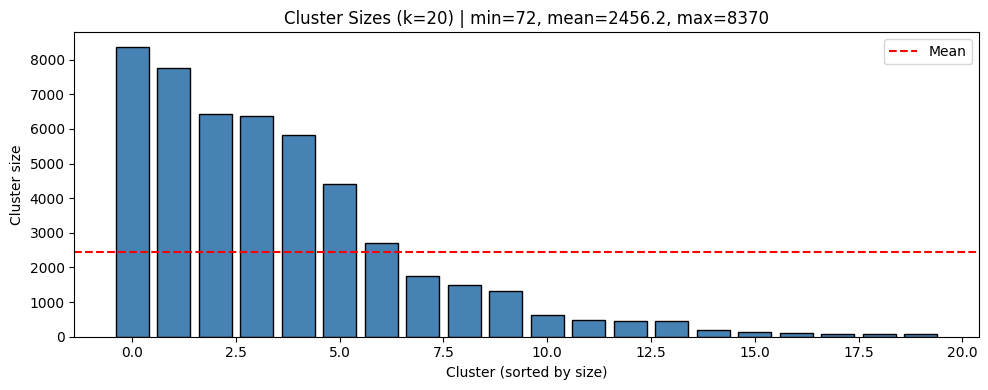

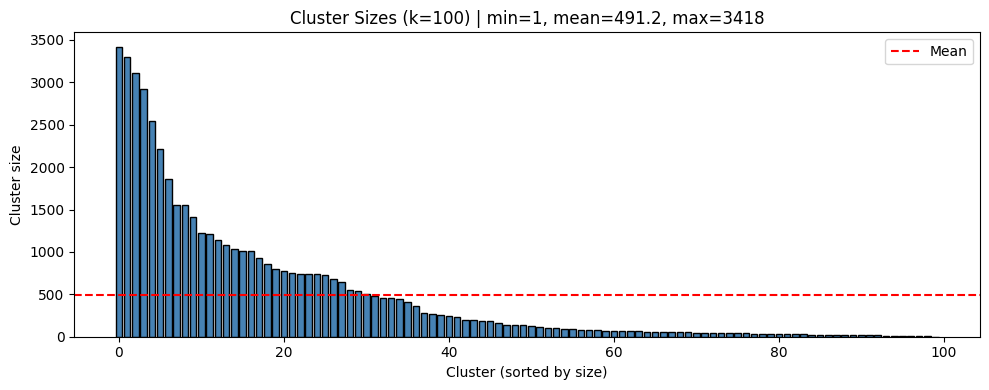

In [7]:
# Cluster size distributions
for k in K_VALUES:
    label_counts = parsed[k]['label_counts']
    if label_counts is None:
        print(f"k={k}: no cluster labels available for size plots")
        continue

    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.bar(range(k), np.sort(label_counts)[::-1], color='steelblue', edgecolor='black')
    ax.set_title(f'Cluster Sizes (k={k}) | min={label_counts.min()}, mean={label_counts.mean():.1f}, max={label_counts.max()}')
    ax.set_xlabel('Cluster (sorted by size)')
    ax.set_ylabel('Cluster size')
    ax.axhline(label_counts.mean(), color='red', linestyle='--', label='Mean')
    ax.legend()
    plt.tight_layout()
    plt.show()


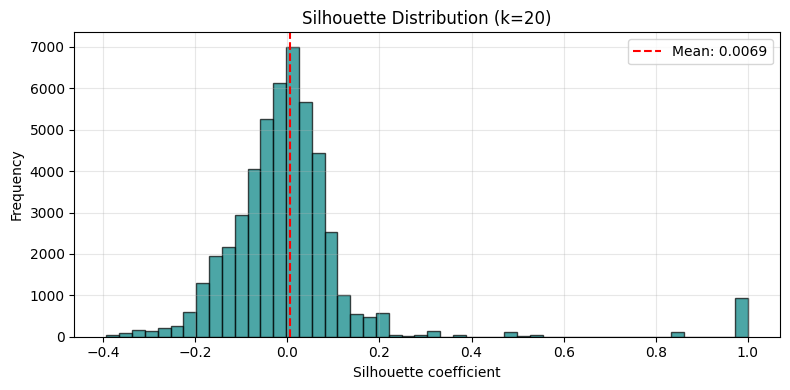

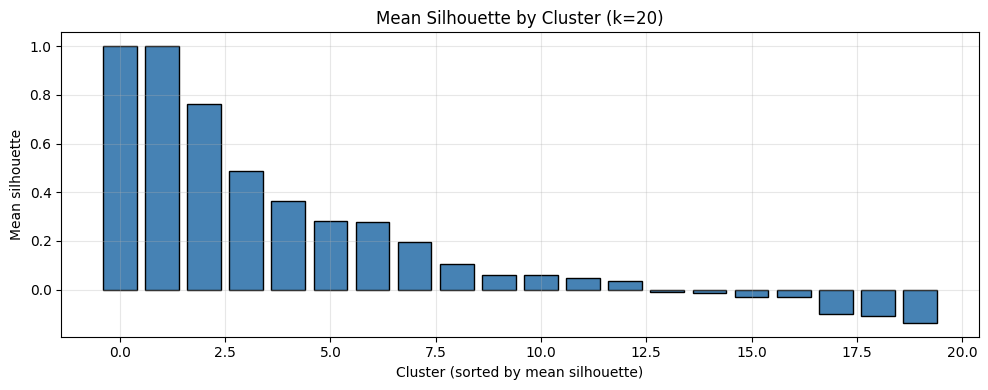

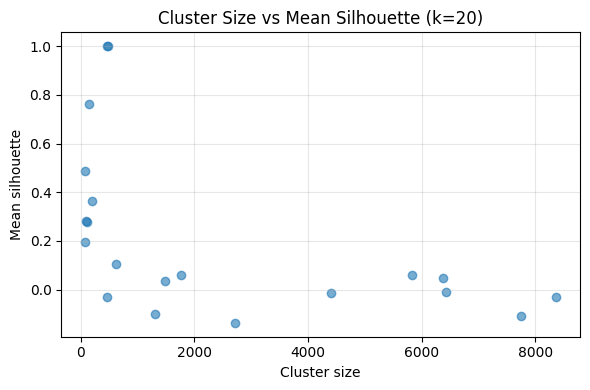

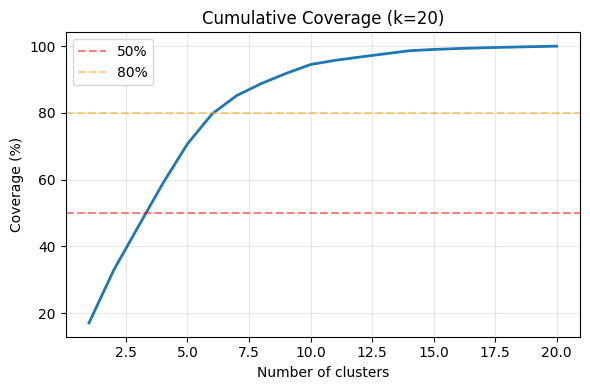

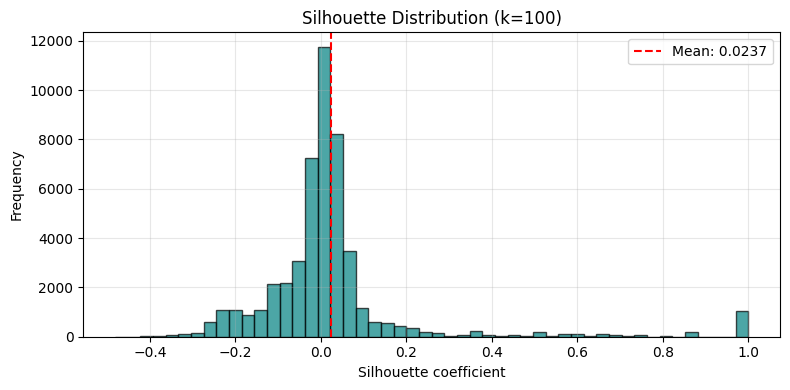

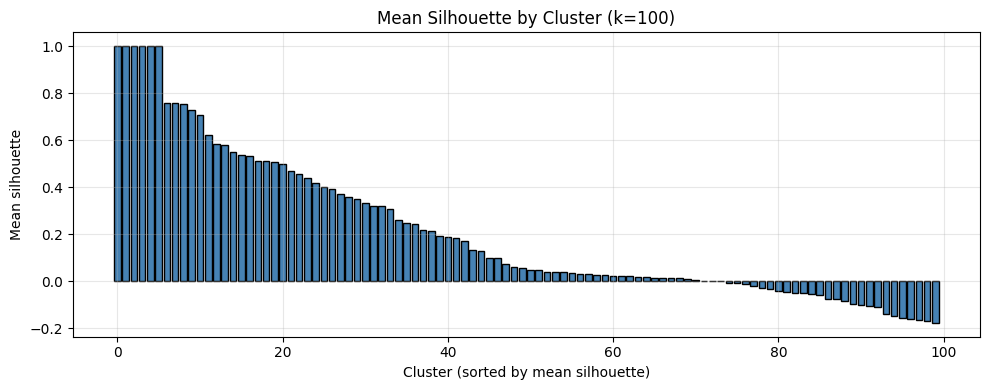

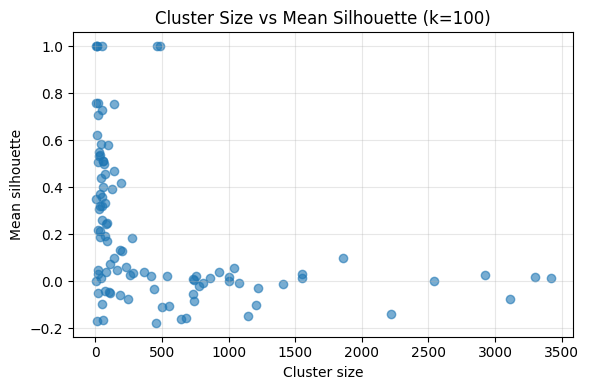

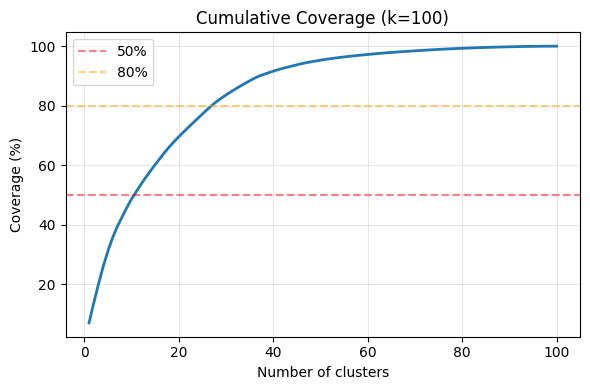

In [8]:
# --- Silhouette & cluster visualizations (full) ---
for k in K_VALUES:
    if k not in full_silhouette:
        continue

    sil = full_silhouette[k]
    labels = np.asarray(parsed[k]['cluster_labels'], dtype=int)
    cluster_sizes = np.bincount(labels, minlength=k)
    cluster_means = np.array([
        sil[labels == c].mean() if cluster_sizes[c] > 0 else np.nan
        for c in range(k)
    ])

    # 1) Silhouette distribution
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.hist(sil, bins=50, color='teal', edgecolor='black', alpha=0.7)
    ax.axvline(sil.mean(), color='red', linestyle='--', label=f"Mean: {sil.mean():.4f}")
    ax.set_title(f"Silhouette Distribution (k={k})")
    ax.set_xlabel('Silhouette coefficient')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2) Mean silhouette per cluster (sorted)
    order = np.argsort(cluster_means)[::-1]
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.bar(range(k), cluster_means[order], color='steelblue', edgecolor='black')
    ax.set_title(f"Mean Silhouette by Cluster (k={k})")
    ax.set_xlabel('Cluster (sorted by mean silhouette)')
    ax.set_ylabel('Mean silhouette')
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 3) Cluster size vs mean silhouette
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.scatter(cluster_sizes, cluster_means, alpha=0.6)
    ax.set_title(f"Cluster Size vs Mean Silhouette (k={k})")
    ax.set_xlabel('Cluster size')
    ax.set_ylabel('Mean silhouette')
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 4) Cumulative coverage
    weights = cluster_sizes / cluster_sizes.sum()
    cumulative = np.cumsum(np.sort(weights)[::-1])
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(range(1, k + 1), cumulative * 100, linewidth=2)
    ax.axhline(50, color='red', linestyle='--', alpha=0.5, label='50%')
    ax.axhline(80, color='orange', linestyle='--', alpha=0.5, label='80%')
    ax.set_title(f"Cumulative Coverage (k={k})")
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Coverage (%)')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



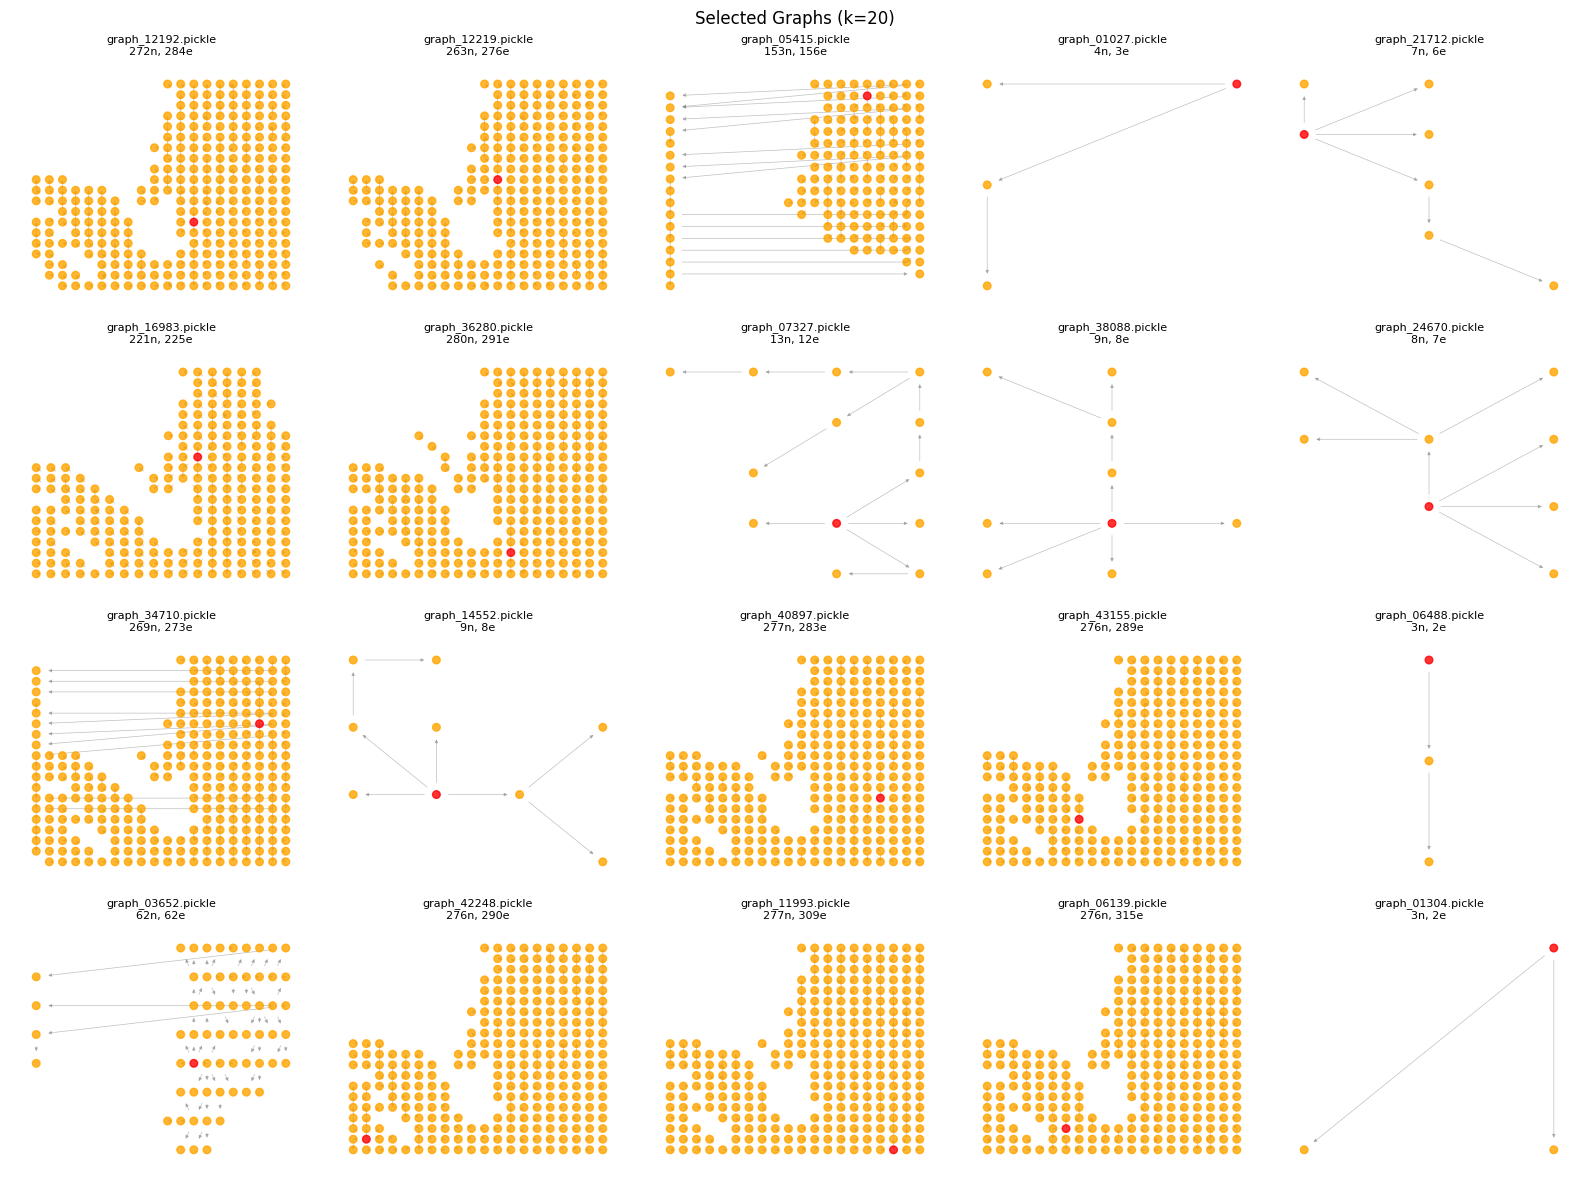

In [9]:
def load_graph_by_name(filename):
    with open(GRAPHS_DIR / filename, 'rb') as f:
        return pickle.load(f)


def graph_stats(G):
    return {
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'density': nx.density(G) if G.number_of_nodes() > 1 else 0.0,
    }


def grid_positions_20(G):
    nodes = list(G.nodes())
    if not nodes:
        return None
    if not all(isinstance(n, (int, np.integer)) for n in nodes):
        return None
    min_n = int(min(nodes))
    max_n = int(max(nodes))
    if 0 <= min_n and max_n <= 399:
        offset = 0
    elif 1 <= min_n and max_n <= 400:
        offset = 1
    else:
        return None

    pos = {}
    for node in nodes:
        idx = int(node) - offset
        row = idx // 20
        col = idx % 20
        pos[node] = (col, 19 - row)
    return pos


def draw_fire_spread_graph(G, ax, title=''):
    pos = grid_positions_20(G)
    if pos is None:
        pos = nx.spring_layout(G, seed=42)

    if G.is_directed():
        ignition_nodes = [n for n in G.nodes() if G.in_degree(n) == 0]
    else:
        ignition_nodes = []

    node_colors = ['red' if n in ignition_nodes else 'orange' for n in G.nodes()]

    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=30, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray', alpha=0.5,
                           arrows=G.is_directed(), arrowsize=5, width=0.5)

    ax.set_title(title, fontsize=8)
    ax.set_axis_off()


def plot_selected_graphs(k):
    selected_files = parsed[k]['selected_files']
    if not selected_files:
        print(f"k={k}: no selected files to plot")
        return

    graphs = []
    for fname in selected_files:
        G = load_graph_by_name(fname)
        stats = graph_stats(G)
        graphs.append((fname, G, stats))

    cols = 5
    rows = int(np.ceil(len(graphs) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.2, rows * 3.0))
    axes = np.array(axes).reshape(-1)

    for i, (fname, G, stats) in enumerate(graphs):
        title = f"{fname}\n{stats['nodes']}n, {stats['edges']}e"
        draw_fire_spread_graph(G, axes[i], title)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f"Selected Graphs (k={k})", fontsize=12)
    plt.tight_layout()
    plt.show()


plot_selected_graphs(20)

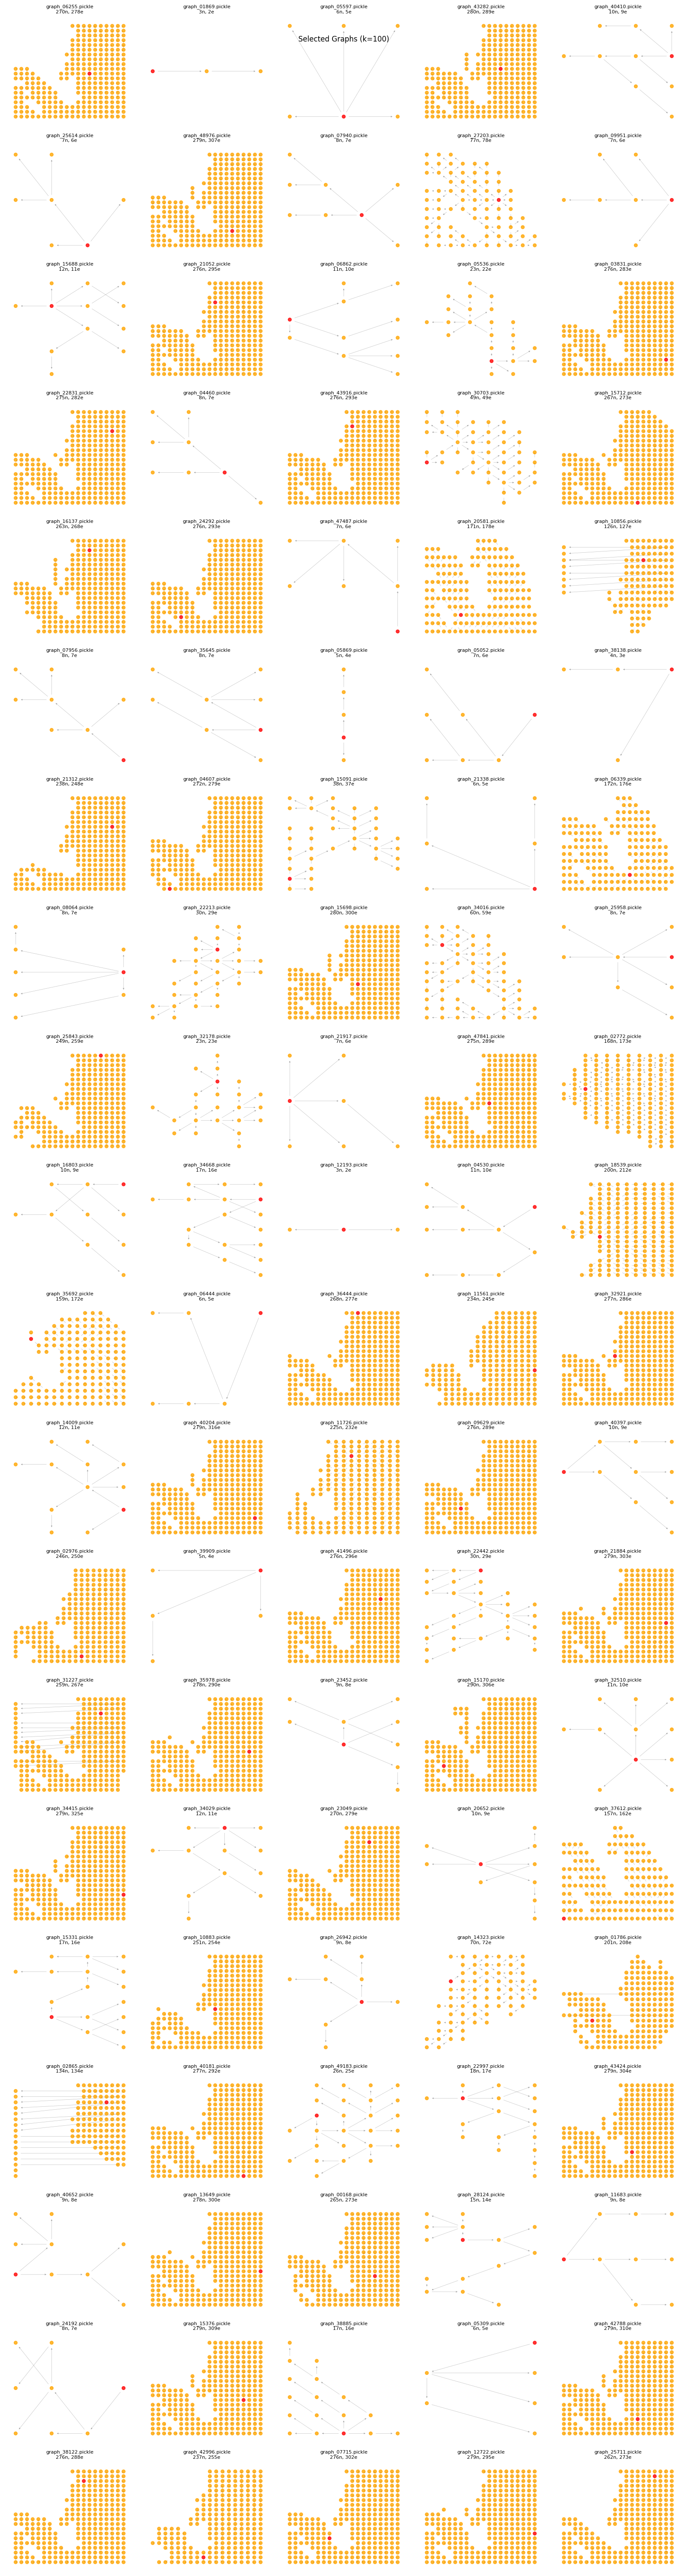

In [10]:
plot_selected_graphs(100)